In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
source = 'train'
destination = 'byteFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination):
    os.makedirs(destination)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    os.rename(source,'asmFiles')
    source='asmFiles'
    data_files = os.listdir(source)
    for file in data_files:
        if (file.endswith("bytes")):
            shutil.move(source+file,destination)

<h2>3.1. Distribution of malware classes in whole data set </h2>

<IPython.core.display.Javascript object>


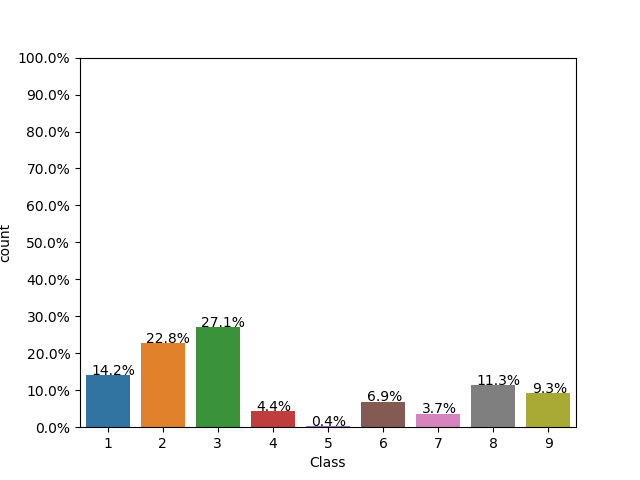

In [2]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

<h2>3.2. Feature extraction </h2>

<h3> 3.2.1 File size  of byte files as a feature </h3>

In [3]:
files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  5.012695      9
1  01IsoiSMh5gxyDYTl4CB  6.556152      2
2  01jsnpXSAlgw6aPeDxrU  4.602051      9
3  01kcPWA9K2BOxQeS5Rju  0.679688      1
4  01SuzwMJEIXsK7A8dQbl  0.438965      8


<h3> 3.2.2 box plots of file size (.byte files) feature </h3>

<IPython.core.display.Javascript object>


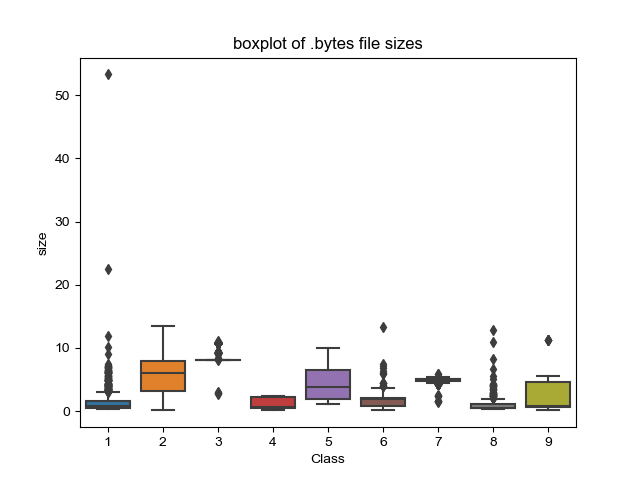

In [4]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

<h3>3.2.3 feature extraction from byte files </h3>

In [7]:
#program to convert into bag of words of bytefiles
#this is custom-built bag of words this is unigram bag of words
byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")
for file in files:
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('byteFiles/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i in feature_matrix[k]:
        byte_feature_file.write(str(i)+",")
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

mk

In [19]:
result = pd.merge(byte_features, data_size_byte,on='ID', how='left')
result.head()

Unnamed: 0                    ID       0     1     2     3     4     5  \
0           0  01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242   
1           1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844   
2           2  01jsnpXSAlgw6aPeDxrU   93506  9542  2568  2438  8925  9330   
3           3  01kcPWA9K2BOxQeS5Rju   21091  1213   726   817  1257   625   
4           4  01SuzwMJEIXsK7A8dQbl   19764   710   302   433   559   410   

      6     7   ...       fb    fc    fd     fe     ff     ??    size_x  \
0  3650  3201   ...     3097  2758  3099   2759   5753   1824  5.012695   
1  8420  7589   ...      302  7639   518  17001  54902   8588  6.556152   
2  9007  2342   ...     2863  2471  2786   2680  49144    468  4.602051   
3   550   523   ...      516  1133   471    761   7998  13940  0.679688   
4   262   249   ...      239   653   221    242   2199   9008  0.438965   

   Class_x    size_y  Class_y  
0        9  5.012695        9  
1        2  6.556152        2  
2        9  4.602051        9  
3        1  0.679688        1  
4        8  0.438965        8  

[5 rows x 263 columns]

In [4]:
byte_features=pd.read_csv("result.csv")
print (byte_features.head())

   Unnamed: 0                    ID       0     1     2     3     4     5  \
0           0  01azqd4InC7m9JpocGv5  601905  3905  2816  3832  3345  3242   
1           1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  7186  8663  6844   
2           2  01jsnpXSAlgw6aPeDxrU   93506  9542  2568  2438  8925  9330   
3           3  01kcPWA9K2BOxQeS5Rju   21091  1213   726   817  1257   625   
4           4  01SuzwMJEIXsK7A8dQbl   19764   710   302   433   559   410   

      6     7  ...      f9    fa    fb    fc    fd     fe     ff     ??  \
0  3650  3201  ...    3101  3211  3097  2758  3099   2759   5753   1824   
1  8420  7589  ...     439   281   302  7639   518  17001  54902   8588   
2  9007  2342  ...    2242  2885  2863  2471  2786   2680  49144    468   
3   550   523  ...     485   462   516  1133   471    761   7998  13940   
4   262   249  ...     350   209   239   653   221    242   2199   9008   

       size  Class  
0  5.012695      9  
1  6.556152      2  
2  4.602051      9  
3 

In [5]:
result=byte_features

In [6]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(result)

In [8]:
joblib.dump(result, 'result.pkl')

['result.pkl']

<h3>3.2.4 Multivariate Analysis </h3>

<IPython.core.display.Javascript object>


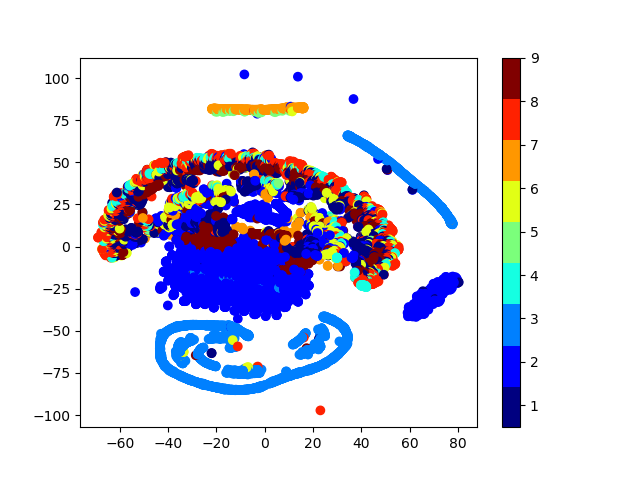

In [11]:
#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<IPython.core.display.Javascript object>


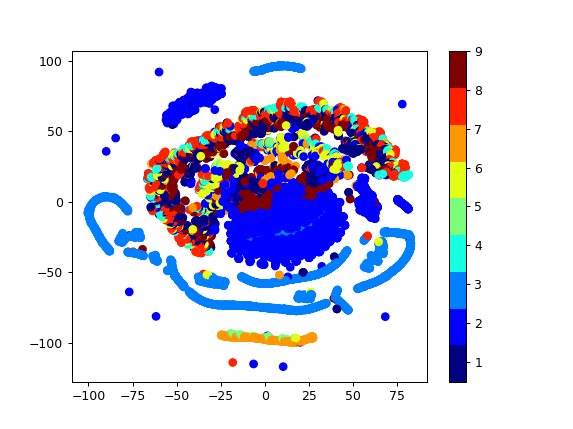

In [15]:
#this is with perplexity 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

# Train Test split

In [9]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [10]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


<IPython.core.display.Javascript object>


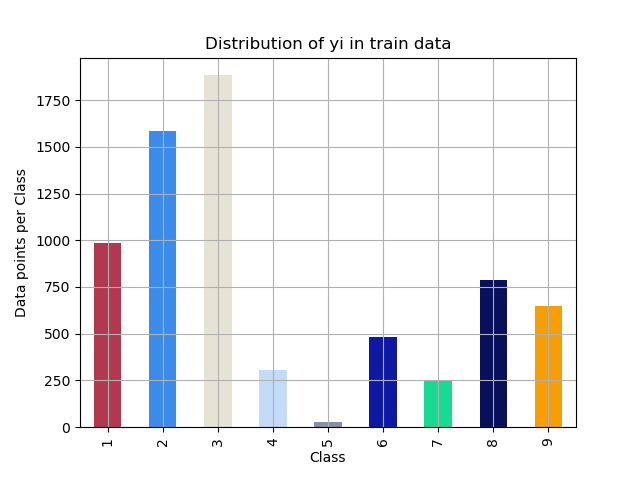

Number of data points in class 3 : 1883 ( 27.074 %)
Number of data points in class 2 : 1586 ( 22.804 %)
Number of data points in class 1 : 986 ( 14.177 %)
Number of data points in class 8 : 786 ( 11.301 %)
Number of data points in class 9 : 648 ( 9.317 %)
Number of data points in class 6 : 481 ( 6.916 %)
Number of data points in class 4 : 304 ( 4.371 %)
Number of data points in class 7 : 254 ( 3.652 %)
Number of data points in class 5 : 27 ( 0.388 %)
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


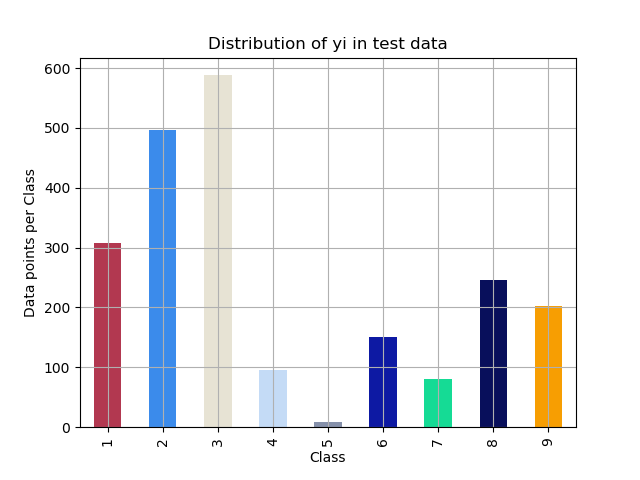

Number of data points in class 3 : 588 ( 27.047 %)
Number of data points in class 2 : 496 ( 22.815 %)
Number of data points in class 1 : 308 ( 14.167 %)
Number of data points in class 8 : 246 ( 11.316 %)
Number of data points in class 9 : 203 ( 9.338 %)
Number of data points in class 6 : 150 ( 6.9 %)
Number of data points in class 4 : 95 ( 4.37 %)
Number of data points in class 7 : 80 ( 3.68 %)
Number of data points in class 5 : 8 ( 0.368 %)
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


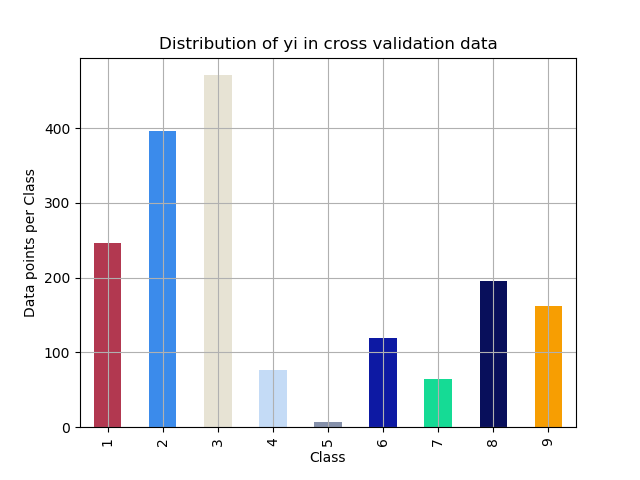

Number of data points in class 3 : 471 ( 27.085 %)
Number of data points in class 2 : 396 ( 22.772 %)
Number of data points in class 1 : 247 ( 14.204 %)
Number of data points in class 8 : 196 ( 11.271 %)
Number of data points in class 9 : 162 ( 9.316 %)
Number of data points in class 6 : 120 ( 6.901 %)
Number of data points in class 4 : 76 ( 4.37 %)
Number of data points in class 7 : 64 ( 3.68 %)
Number of data points in class 5 : 7 ( 0.403 %)


In [11]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()

my_colors = ['#b23850', '#3b8beb', '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = ['#b23850', '#3b8beb', '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = ['#b23850', '#3b8beb', '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


In [13]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h1>4. Machine Learning Models</h1>

<h2>4.1. Machine Leaning Models on bytes files</h2>

<h3>4.1.1. Random Model</h3>

Log loss on Cross Validation Data using Random Model 2.4987116946656167
Log loss on Test Data using Random Model 2.4553327958473936
Number of misclassified points  88.45446182152715
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


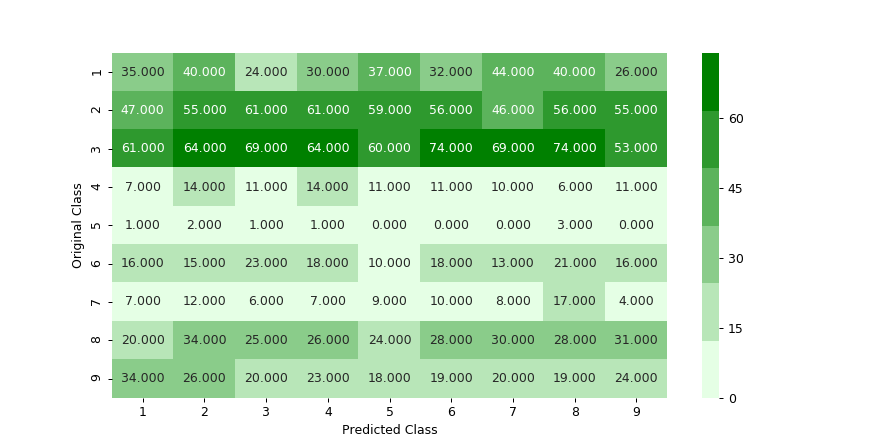

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


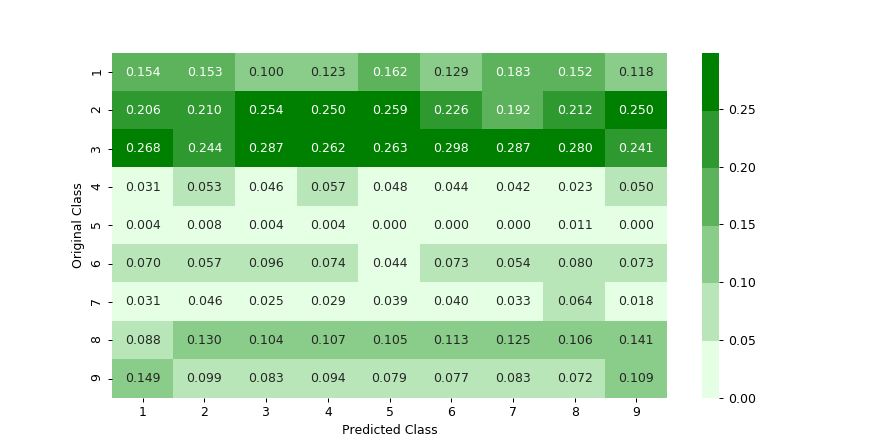

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


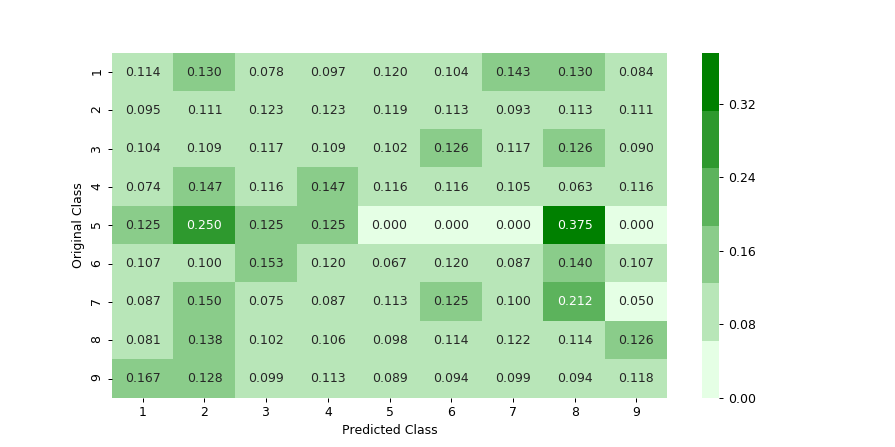

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h3>4.1.2. K Nearest Neighbour Classification</h3>

log_loss for k =  1 is 0.49188045368463196
log_loss for k =  3 is 0.483116902642161
log_loss for k =  5 is 0.5118350087441232
log_loss for k =  7 is 0.5395490778512431
log_loss for k =  9 is 0.5676371813660702
log_loss for k =  11 is 0.5870170308367498
log_loss for k =  13 is 0.606375118318671


<IPython.core.display.Javascript object>


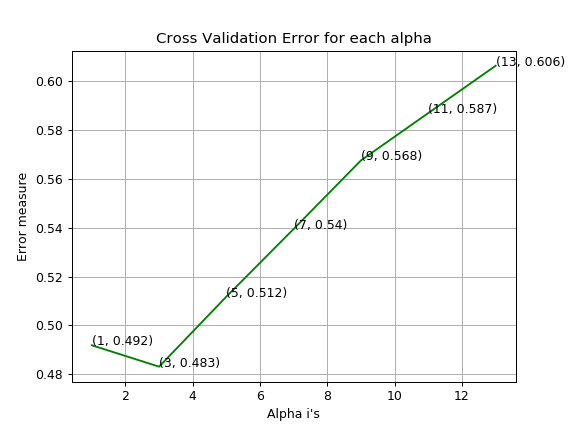

For values of best alpha =  3 The train log loss is: 0.29320594139515405
For values of best alpha =  3 The cross validation log loss is: 0.483116902642161
For values of best alpha =  3 The test log loss is: 0.4851954874286108
Number of misclassified points  12.97148114075437
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


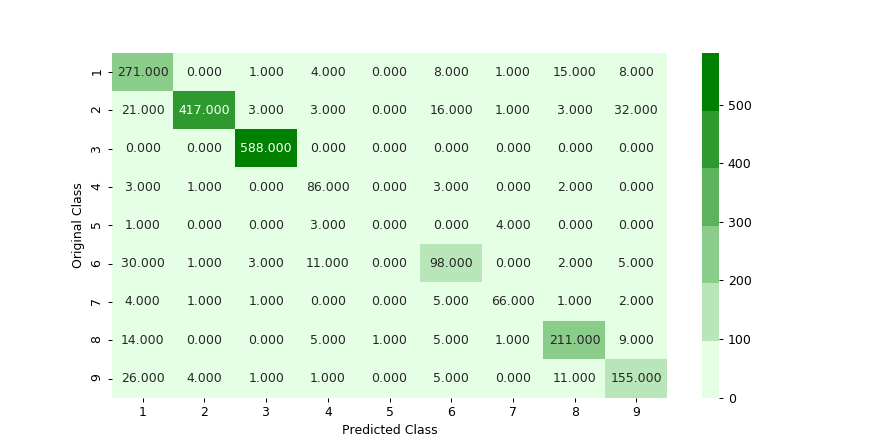

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


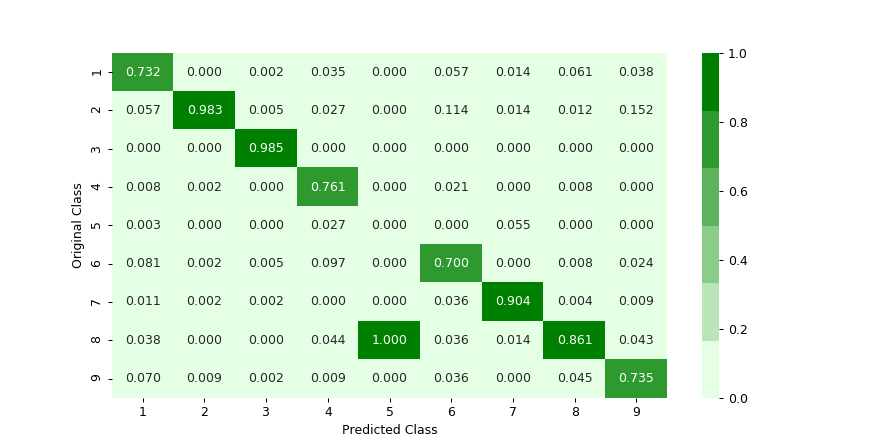

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


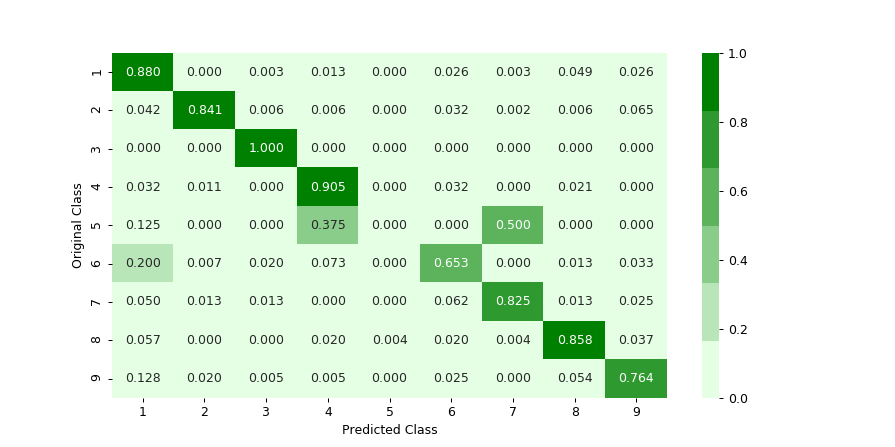

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
  
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>4.1.3. Logistic Regression</h3>

log_loss for c =  1e-05 is 1.8861109311791922
log_loss for c =  0.0001 is 1.8845880471197165
log_loss for c =  0.001 is 1.8614285515198798
log_loss for c =  0.01 is 1.437434379095915
log_loss for c =  0.1 is 0.9337959204695321
log_loss for c =  1 is 0.7667190017910965
log_loss for c =  10 is 0.6257185173536978
log_loss for c =  100 is 0.56294262675526
log_loss for c =  1000 is 0.6385231825855628


<IPython.core.display.Javascript object>


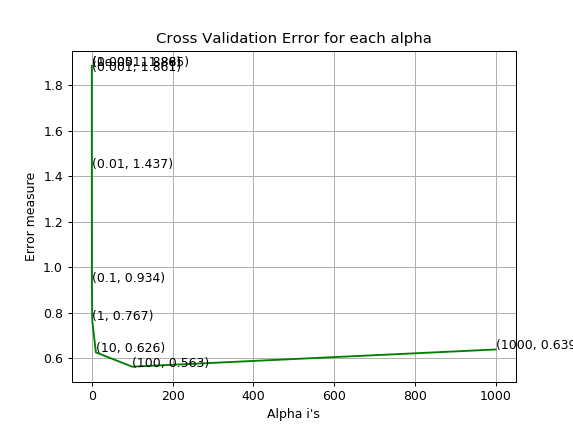

log loss for train data 0.4871437301878761
log loss for cv data 0.56294262675526
log loss for test data 0.5294168099375685
Number of misclassified points  12.603495860165593
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


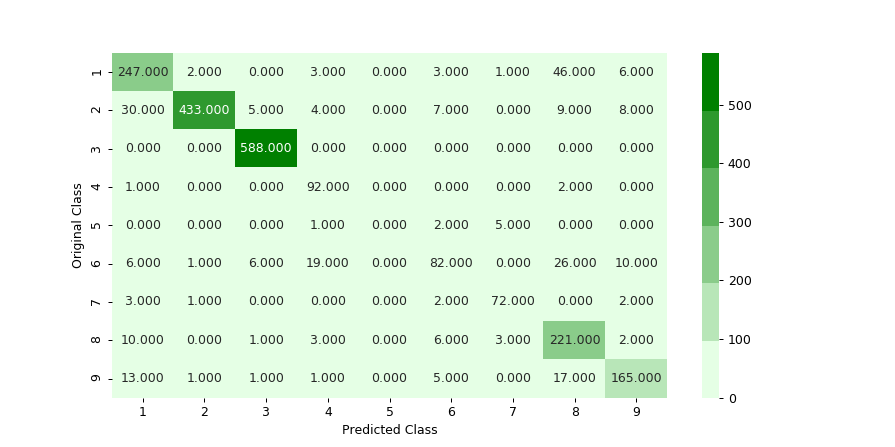

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


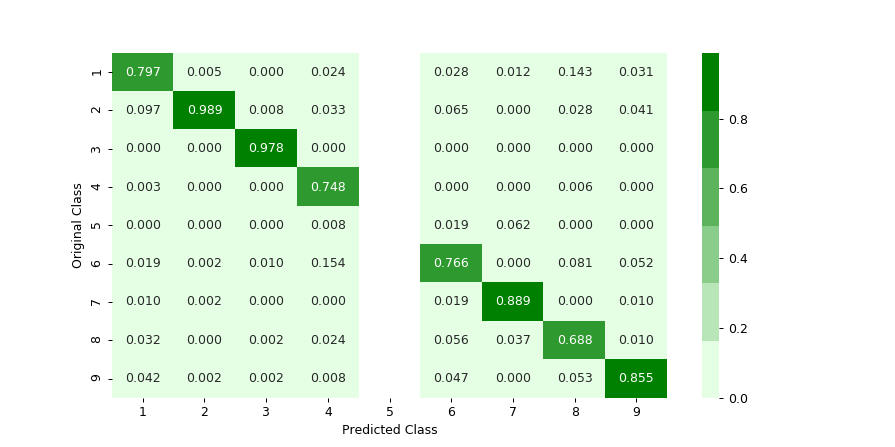

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


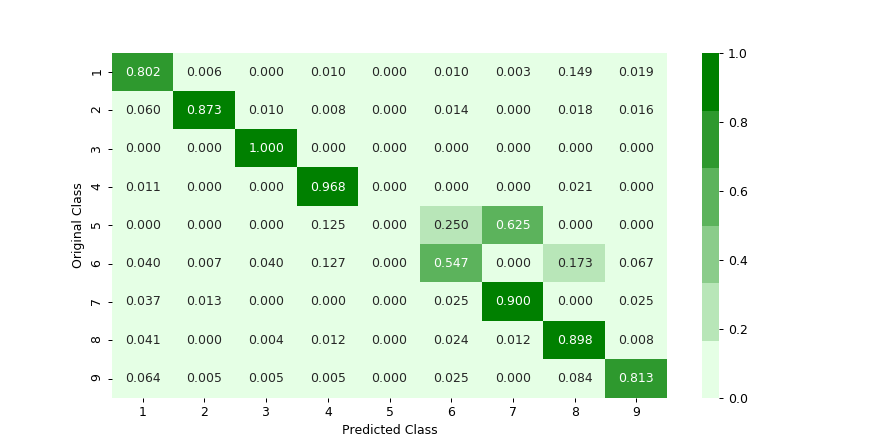

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [22]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3> 4.1.4. Random Forest Classifier </h3>

log_loss for c =  10 is 0.08975272796356877
log_loss for c =  50 is 0.07869374681057625
log_loss for c =  100 is 0.07546292664044586
log_loss for c =  500 is 0.07379883728342362
log_loss for c =  1000 is 0.07302077078516724
log_loss for c =  2000 is 0.07321813574020479
log_loss for c =  3000 is 0.073068132864414


<IPython.core.display.Javascript object>


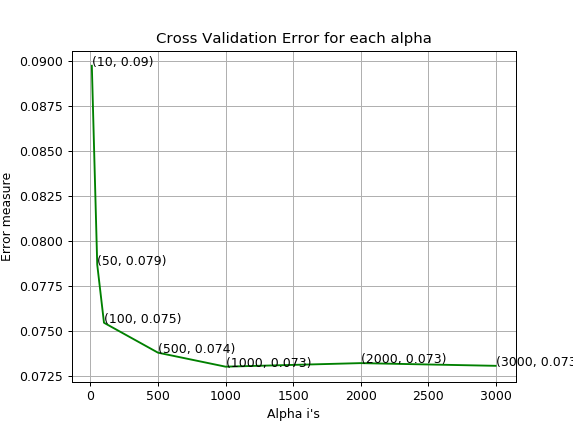

For values of best alpha =  1000 The train log loss is: 0.02941015229514485
For values of best alpha =  1000 The cross validation log loss is: 0.07302077078516724
For values of best alpha =  1000 The test log loss is: 0.06623869322452512
Number of misclassified points  1.2419503219871204
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


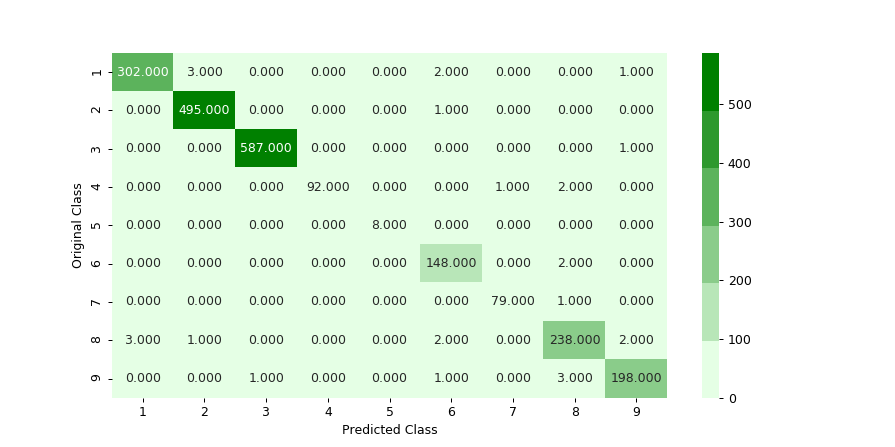

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


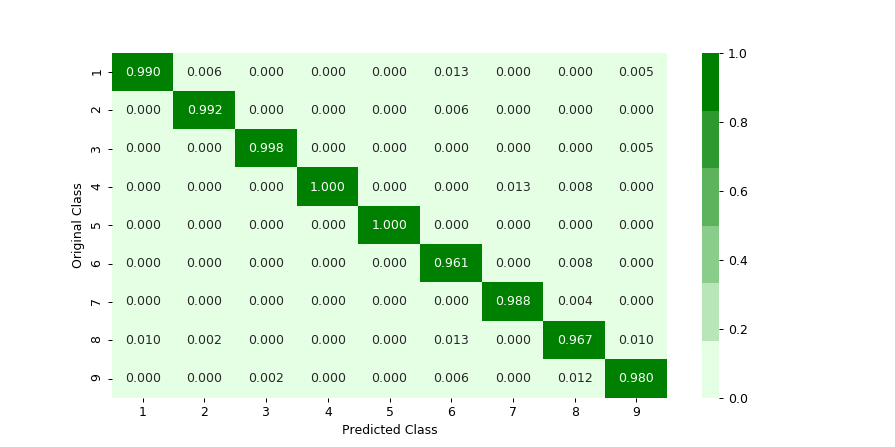

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>4.1.5. XgBoost Classification</h3>

log_loss for c =  10 is 0.18972194520294353
log_loss for c =  50 is 0.10788109266220497
log_loss for c =  100 is 0.0727450829972164
log_loss for c =  500 is 0.059635927131908094
log_loss for c =  1000 is 0.06014538270053144
log_loss for c =  2000 is 0.060249389062255305


<IPython.core.display.Javascript object>


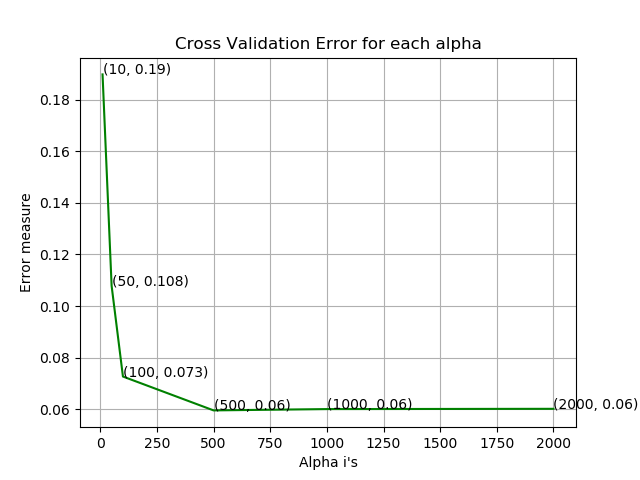

For values of best alpha =  500 The train log loss is: 0.02468009568654092
For values of best alpha =  500 The cross validation log loss is: 0.059635927131908094
For values of best alpha =  500 The test log loss is: 0.07847700799402009


In [14]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

Number of misclassified points  1.6559337626494939
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


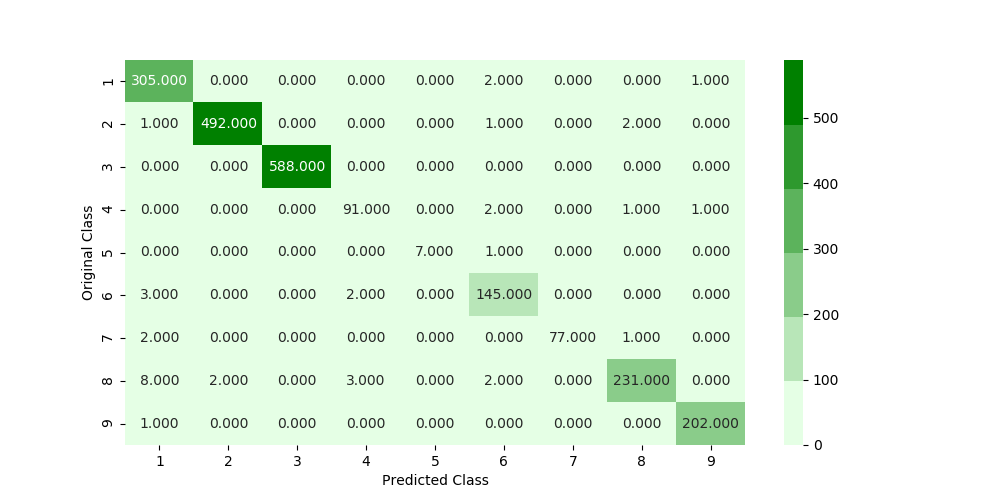

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


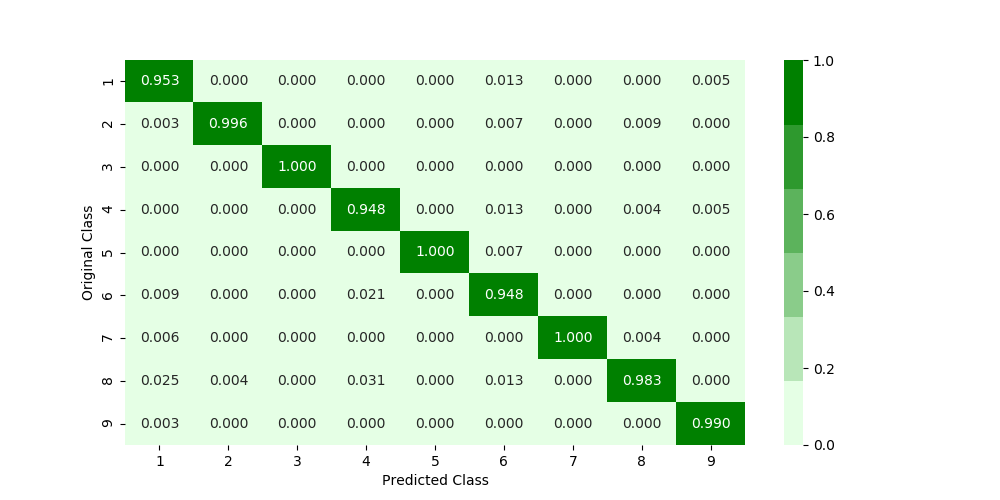

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


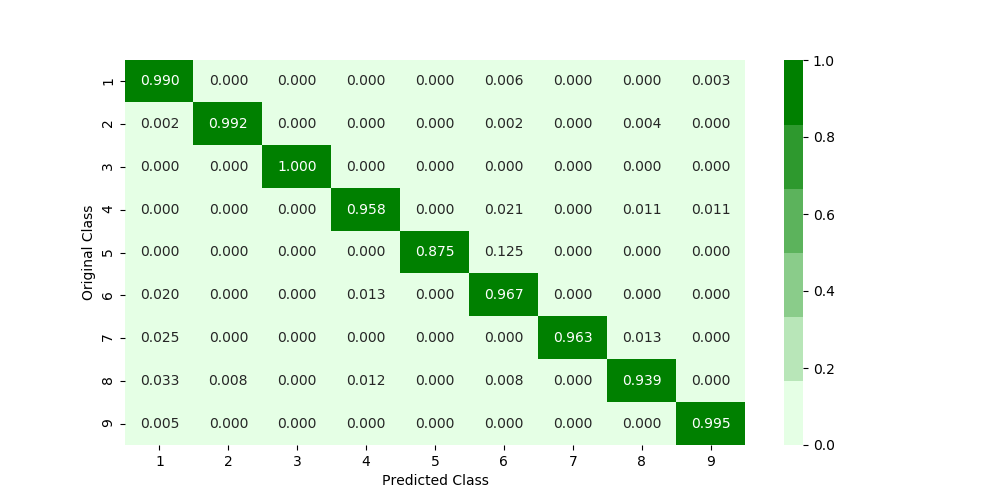

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>4.1.5. XgBoost Classification with best hyper parameters using RandomSearch </h3>

In [22]:

x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 48.9min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 54.2min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 500, 1000, 2000], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.1, 0.3, 0.5, 1], 'subsample': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [ ]:
print (random_cfl1.best_params_)

{'subsample': 1, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5}


In [16]:

x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.01, colsample_bytree=0.5, max_depth=5,subsample=1)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.024348854759529453
cv loss 0.06210692336009718
test loss 0.07717065282799755


<h2> 4.2 Modeling with .asm files </h2>

<pre>
There are 10868 files of asm 
All the files make up about 150 GB
The asm files contains :
1. Address
2. Segments
3. Opcodes
4. Registers
5. function calls
6. APIs
With the help of parallel processing we extracted all the features.In parallel we can use all the cores that are present in our computer.


Here we extracted 52 features from all the asm files which are important.

We read the top solutions and handpicked the features from those papers/videos/blogs. <br> Refer:https://www.kaggle.com/c/malware-classification/discussion
</pre>

<h3> 4.2.1 Feature extraction from asm files </h3>

<p>
<li> To extract the unigram features from the .asm files we need to process ~150GB of data </li>
<li style="font-size:18px"><b>Note: Below two cells will take lot of time (over 48 hours to complete)</b></li>
<li> We will provide you the output file of these two cells, which you can directly use it </li>
</p>

In [ ]:
#intially create five folders
#first 
#second
#thrid
#fourth
#fifth
#this code tells us about random split of files into five folders
folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='train/'
files = os.listdir('train')
ID=df['Id'].tolist()
data=range(0,10868)
r.shuffle(data)
count=0
for i in range(0,10868):
    if i % 5==0:
        shutil.move(source+files[data[i]],'first')
    elif i%5==1:
        shutil.move(source+files[data[i]],'second')
    elif i%5 ==2:
        shutil.move(source+files[data[i]],'thrid')
    elif i%5 ==3:
        shutil.move(source+files[data[i]],'fourth')
    elif i%5==4:
        shutil.move(source+files[data[i]],'fifth')

In [ ]:

#http://flint.cs.yale.edu/cs421/papers/x86-asm/asm.html

def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\asmsmallfile.txt","w+")
    files = os.listdir('first')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\mediumasmfile.txt","w+")
    files = os.listdir('second')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\largeasmfile.txt","w+")
    files = os.listdir('thrid')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('thrid/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\hugeasmfile.txt","w+")
    files = os.listdir('fourth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fifthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\trainasmfile.txt","w+")
    files = os.listdir('fifth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fifth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming
    manager=multiprocessing.Manager() 	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    p5=Process(target=fifthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()

if __name__=="__main__":
    main()

In [14]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# this file will be uploaded in the drive, you can directly use this
dfasm=pd.read_csv("asmoutputfile.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(dfasm, Y,on='ID', how='left')
result_asm.head()

ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:  ...    edx  esi  eax  ebx  ecx  edi  ebp  esp  \
0      323        0       3  ...     18   66   15   43   83    0   17   48   
1        0        0       3  ...     18   29   48   82   12    0   14    0   
2      145        0       3  ...     13   42   10   67   14    0   11    0   
3        0        0       3  ...      6    8   14    7    2    0    8    0   
4        0        0       3  ...     12    9   18   29    5    0   11    0   

   eip  Class  
0   29      1  
1   20      1  
2    9      1  
3    6      1  
4   11      1  

[5 rows x 53 columns]

<h4> 4.2.1.1 Files sizes of each .asm file </h4>

In [15]:
#file sizes of byte files

files=os.listdir('asmFiles')
filenames=Y['ID'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

                     ID       size  Class
0  01azqd4InC7m9JpocGv5  56.229886      9
1  01IsoiSMh5gxyDYTl4CB  13.999378      2
2  01jsnpXSAlgw6aPeDxrU   8.507785      9
3  01kcPWA9K2BOxQeS5Rju   0.078190      1
4  01SuzwMJEIXsK7A8dQbl   0.996723      8


<h4> 4.2.1.2 Distribution of .asm file sizes</h4>

<IPython.core.display.Javascript object>


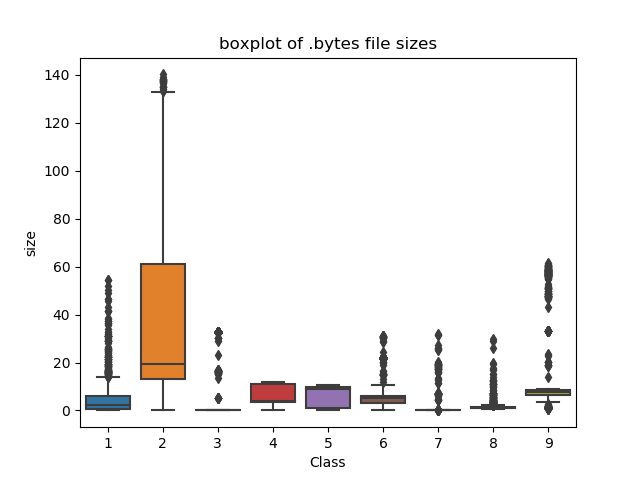

In [15]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [16]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class'], axis=1),on='ID', how='left')
result_asm.head()

(10868, 53)
(10868, 3)


ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:    ...     esi  eax  ebx  ecx  edi  ebp  esp  eip  \
0      323        0       3    ...      66   15   43   83    0   17   48   29   
1        0        0       3    ...      29   48   82   12    0   14    0   20   
2      145        0       3    ...      42   10   67   14    0   11    0    9   
3        0        0       3    ...       8   14    7    2    0    8    0    6   
4        0        0       3    ...       9   18   29    5    0   11    0   11   

   Class      size  
0      1  0.078190  
1      1  0.063400  
2      1  0.041695  
3      1  0.018757  
4      1  0.037567  

[5 rows x 54 columns]

In [17]:
# we normalize the data each column 
result_asm.head()

ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:    ...     esi  eax  ebx  ecx  edi  ebp  esp  eip  \
0      323        0       3    ...      66   15   43   83    0   17   48   29   
1        0        0       3    ...      29   48   82   12    0   14    0   20   
2      145        0       3    ...      42   10   67   14    0   11    0    9   
3        0        0       3    ...       8   14    7    2    0    8    0    6   
4        0        0       3    ...       9   18   29    5    0   11    0   11   

   Class      size  
0      1  0.078190  
1      1  0.063400  
2      1  0.041695  
3      1  0.018757  
4      1  0.037567  

[5 rows x 54 columns]

<h3> 4.2.2 Univariate analysis on  asm file features</h3>

<IPython.core.display.Javascript object>


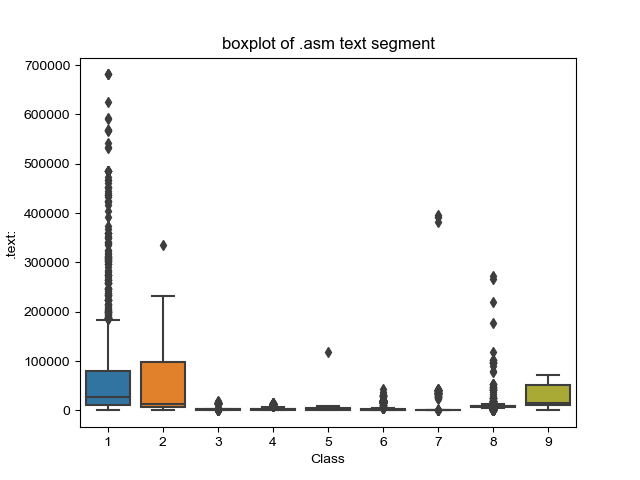

In [18]:
ax = sns.boxplot(x="Class", y=".text:", data=result_asm)
plt.title("boxplot of .asm text segment")
plt.show()

<pre>
The plot is between Text and class 
Class 1,2 and 9 can be easly separated
</pre>

<IPython.core.display.Javascript object>


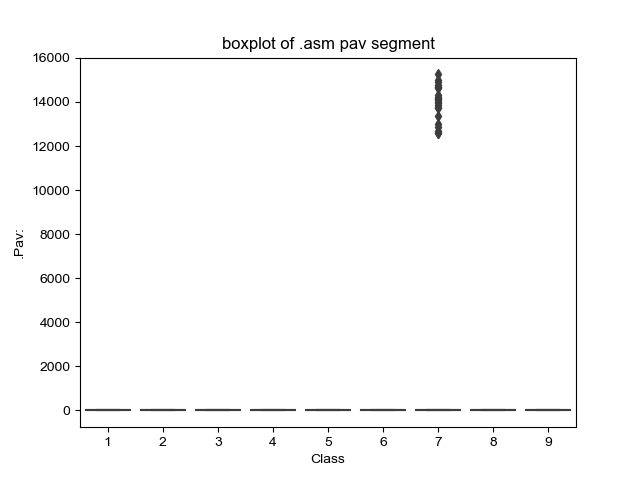

In [19]:
ax = sns.boxplot(x="Class", y=".Pav:", data=result_asm)
plt.title("boxplot of .asm pav segment")
plt.show()

<IPython.core.display.Javascript object>


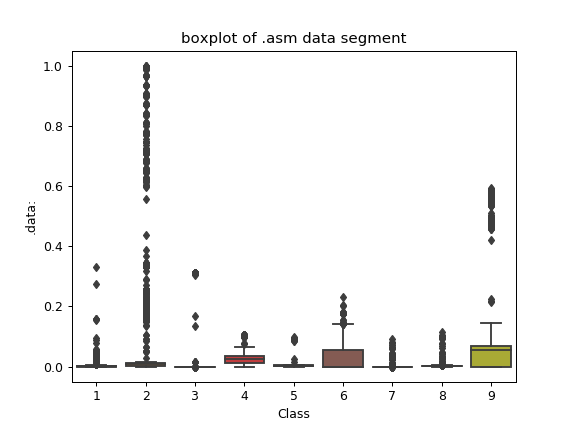

In [19]:
ax = sns.boxplot(x="Class", y=".data:", data=result_asm)
plt.title("boxplot of .asm data segment")
plt.show()

<pre>
The plot is between data segment and class label 
class 6 and class 9 can be easily separated from given points
</pre>

<IPython.core.display.Javascript object>


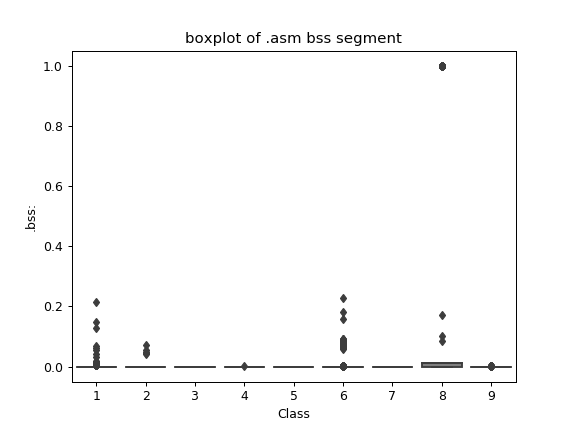

In [20]:
ax = sns.boxplot(x="Class", y=".bss:", data=result_asm)
plt.title("boxplot of .asm bss segment")
plt.show()

<pre>
plot between bss segment and class label
very less number of files are having bss segment
</pre>

<IPython.core.display.Javascript object>


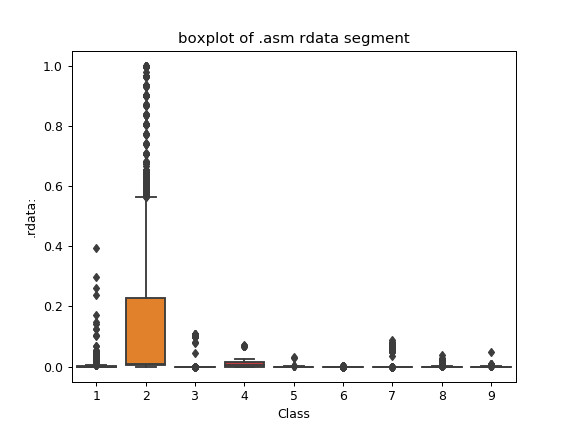

In [21]:
ax = sns.boxplot(x="Class", y=".rdata:", data=result_asm)
plt.title("boxplot of .asm rdata segment")
plt.show()

<pre>
Plot between rdata segment and Class segment
Class 2 can be easily separated 75 pecentile files are having 1M rdata lines
</pre>

<IPython.core.display.Javascript object>


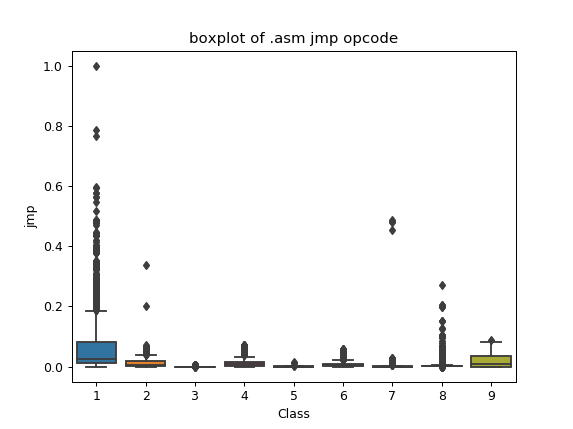

In [22]:
ax = sns.boxplot(x="Class", y="jmp", data=result_asm)
plt.title("boxplot of .asm jmp opcode")
plt.show()

<pre>
plot between jmp and Class label
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

<IPython.core.display.Javascript object>


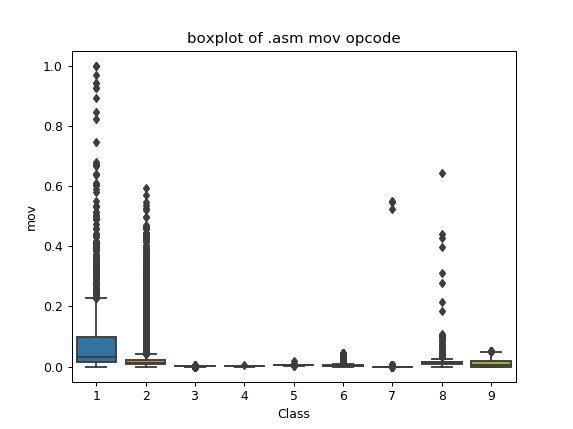

In [23]:
ax = sns.boxplot(x="Class", y="mov", data=result_asm)
plt.title("boxplot of .asm mov opcode")
plt.show()

<pre>
plot between Class label and mov opcode
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

<IPython.core.display.Javascript object>


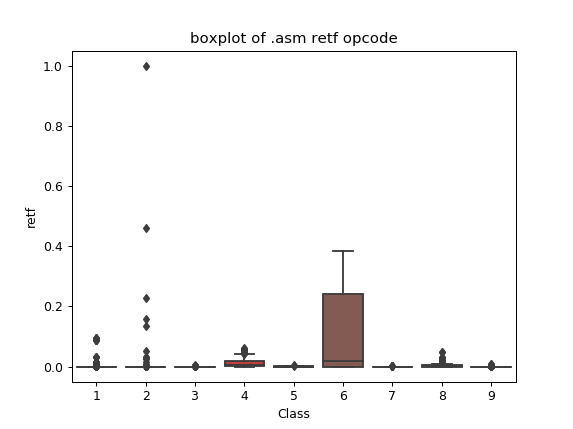

In [24]:
ax = sns.boxplot(x="Class", y="retf", data=result_asm)
plt.title("boxplot of .asm retf opcode")
plt.show()

<pre>
plot between Class label and retf
Class 6 can be easily separated with opcode retf
The frequency of retf is approx of 250.
</pre>

<IPython.core.display.Javascript object>


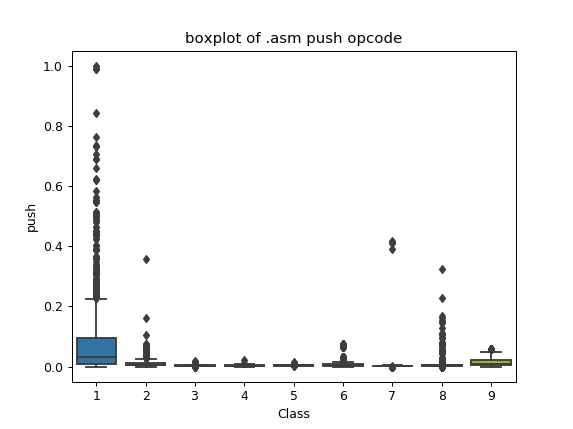

In [25]:
ax = sns.boxplot(x="Class", y="push", data=result_asm)
plt.title("boxplot of .asm push opcode")
plt.show()

<pre>
plot between push opcode and Class label
Class 1 is having 75 precentile files with push opcodes of frequency 1000
</pre>

<h3> 4.2.2 Multivariate Analysis on .asm file features </h3>

<IPython.core.display.Javascript object>


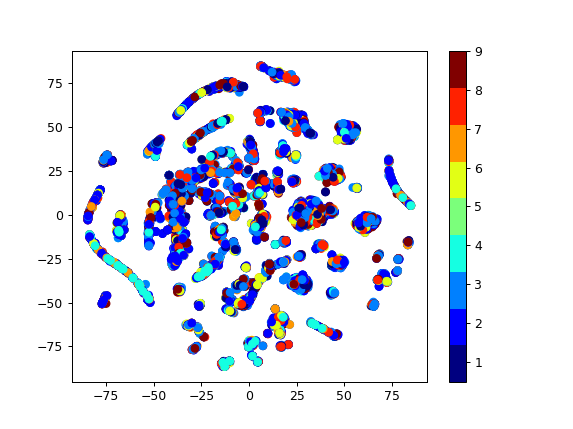

In [16]:
# check out the course content for more explantion on tsne algorithm
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/t-distributed-stochastic-neighbourhood-embeddingt-sne-part-1/

#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_asm.drop(['ID','Class'], axis=1).fillna(0))
vis_x = results[:, 0]
vis_y = results[:, 1   ]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<IPython.core.display.Javascript object>


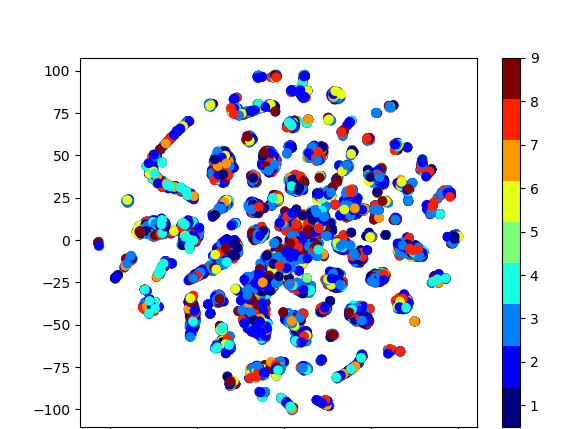

In [30]:
# by univariate analysis on the .asm file features we are getting very negligible information from 
# 'rtn', '.BSS:' '.CODE' features, so heare we are trying multivariate analysis after removing those features
# the plot looks very messy

xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result_asm.drop(['ID','Class', 'rtn', '.BSS:', '.CODE','size'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<pre>
TSNE for asm data with perplexity 50
</pre>

<h3> 4.2.3 Conclusion on EDA</h3>

<p>
<li>We have taken only 52 features from asm files (after reading through many blogs and research papers) </li>
<li>The univariate analysis was done only on few important features.</li>
<li>Take-aways
<ul>
<li>1. Class 3 can be easily separated because of the frequency of segments,opcodes and keywords being less </li>
<li>2. Each feature has its unique importance in separating the Class labels.</li>
</ul>
</li>
</p>

<h2> 4.3 Train and test split</h2>

In [18]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['ID','Class','.BSS:','rtn','.CODE'], axis=1)

In [19]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [20]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
.bss:      False
.rdata:    False
.edata:    False
.rsrc:     False
.tls:      False
.reloc:    False
jmp        False
mov        False
retf       False
push       False
pop        False
xor        False
retn       False
nop        False
sub        False
inc        False
dec        False
add        False
imul       False
xchg       False
or         False
shr        False
cmp        False
call       False
shl        False
ror        False
rol        False
jnb        False
jz         False
lea        False
movzx      False
.dll       False
std::      False
:dword     False
edx        False
esi        False
eax        False
ebx        False
ecx        False
edi        False
ebp        False
esp        False
eip        False
size       False
dtype: bool


<h2> 4.4. Machine Learning models on features of .asm files</h2>

<h3> 4.4.1 K-Nearest Neigbors </h3>

log_loss for k =  1 is 0.2286951008264786
log_loss for k =  3 is 0.23974604909767921
log_loss for k =  5 is 0.26743767182569295
log_loss for k =  7 is 0.2922812711849662
log_loss for k =  9 is 0.3173517943176062
log_loss for k =  11 is 0.3375272301343973
log_loss for k =  13 is 0.3542581717184334
log_loss for k =  15 is 0.3703567252351854
log_loss for k =  17 is 0.3857570471590401
log_loss for k =  19 is 0.40090334916939535


<IPython.core.display.Javascript object>


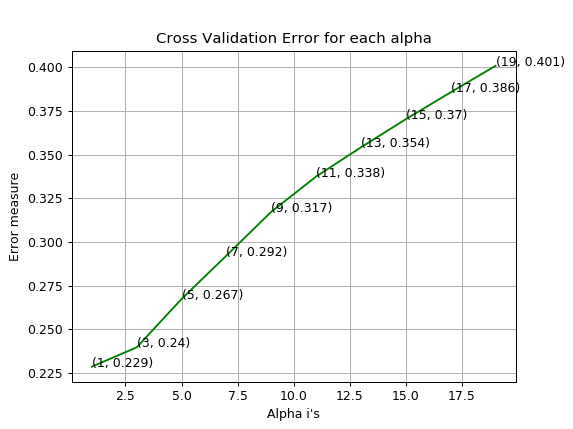

log loss for train data 0.07371820550676085
log loss for cv data 0.2286951008264786
log loss for test data 0.2135354369723588
Number of misclassified points  4.001839926402944
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


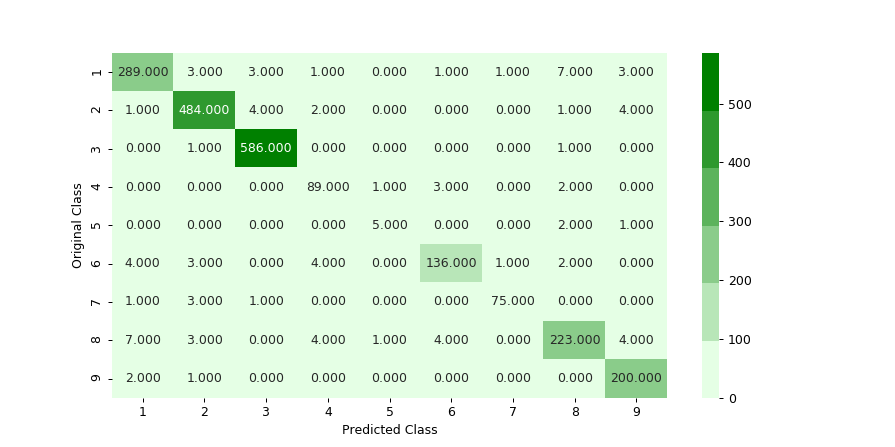

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


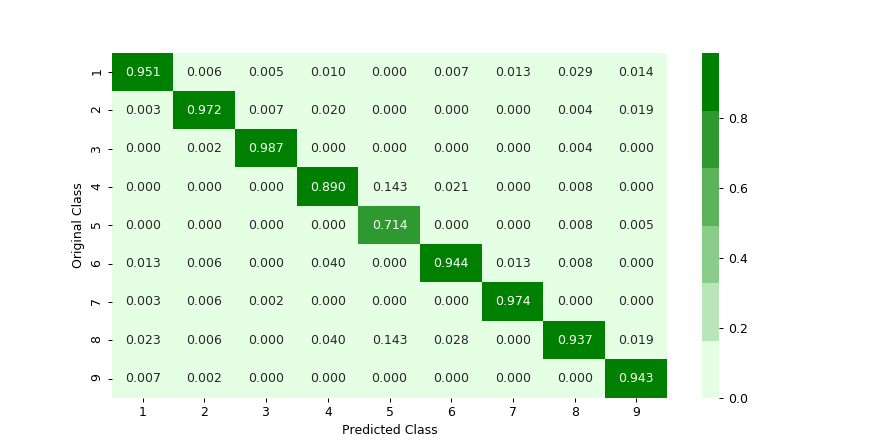

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


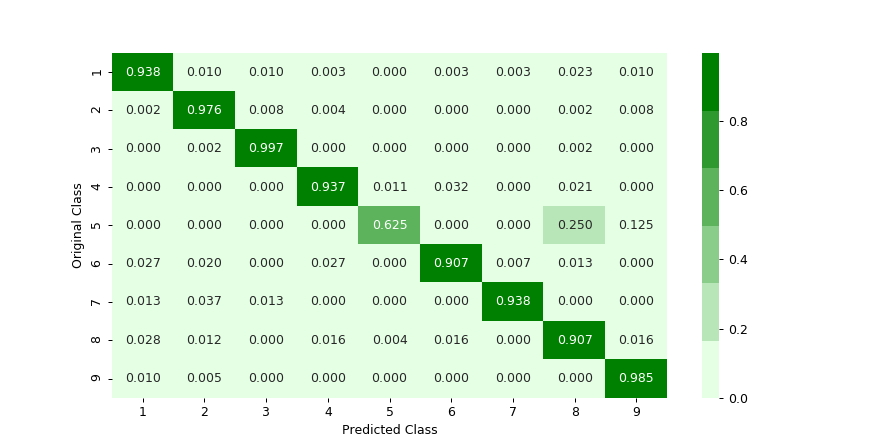

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.2 Logistic Regression </h3>

log_loss for c =  1e-05 is 1.6869859868957804
log_loss for c =  0.0001 is 1.6855010192472757
log_loss for c =  0.001 is 1.6755781562152487
log_loss for c =  0.01 is 1.5677273322121714
log_loss for c =  0.1 is 1.3002573116338927
log_loss for c =  1 is 0.856048258533692
log_loss for c =  10 is 0.5735687649879864
log_loss for c =  100 is 0.4431214718098947
log_loss for c =  1000 is 0.43157353232283385


<IPython.core.display.Javascript object>


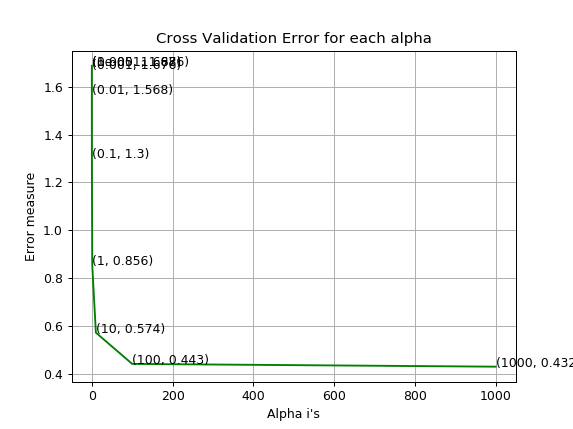

log loss for train data 0.38150548196180933
log loss for cv data 0.43157353232283385
log loss for test data 0.38308926013384326
Number of misclassified points  7.405703771849126
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


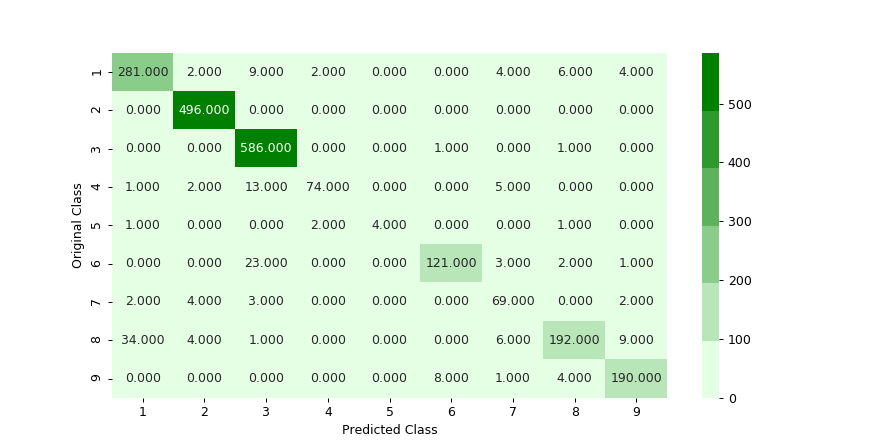

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


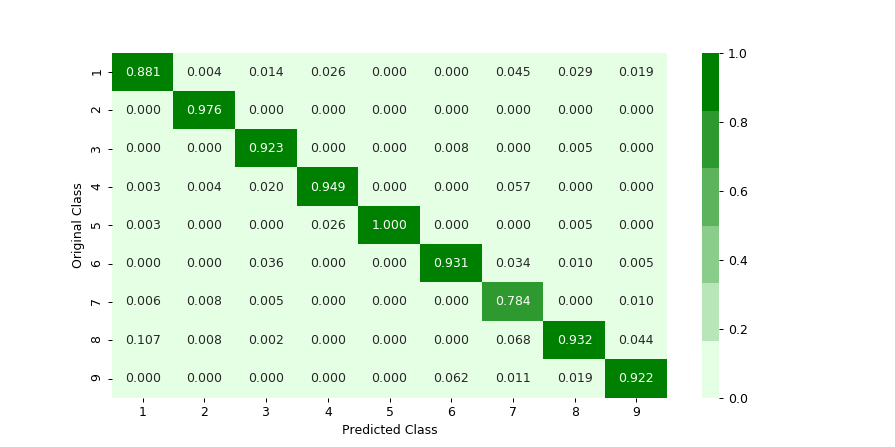

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


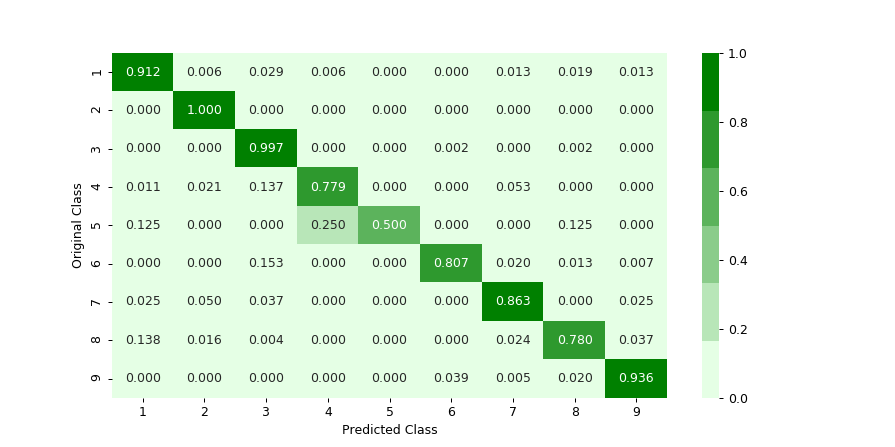

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [36]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.3 Random Forest Classifier</h3>

log_loss for c =  10 is 0.044604000720488056
log_loss for c =  50 is 0.038892329851189296
log_loss for c =  100 is 0.03875524544813011
log_loss for c =  500 is 0.039224440805809314
log_loss for c =  1000 is 0.03945941790783839
log_loss for c =  2000 is 0.03953659123286974
log_loss for c =  3000 is 0.03950608587732239


<IPython.core.display.Javascript object>


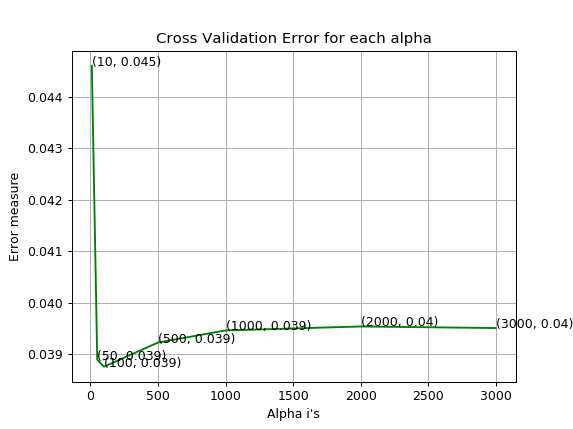

log loss for train data 0.012379247850927044
log loss for cv data 0.03875524544813011
log loss for test data 0.039428378936875376
Number of misclassified points  0.8279668813247469
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


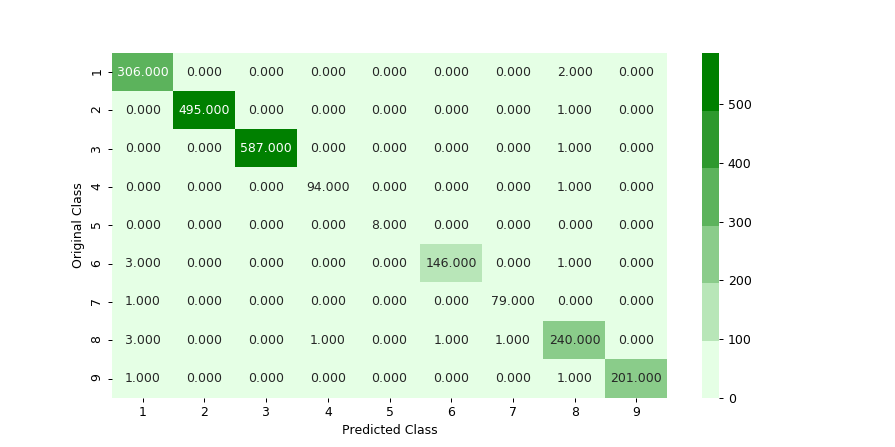

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


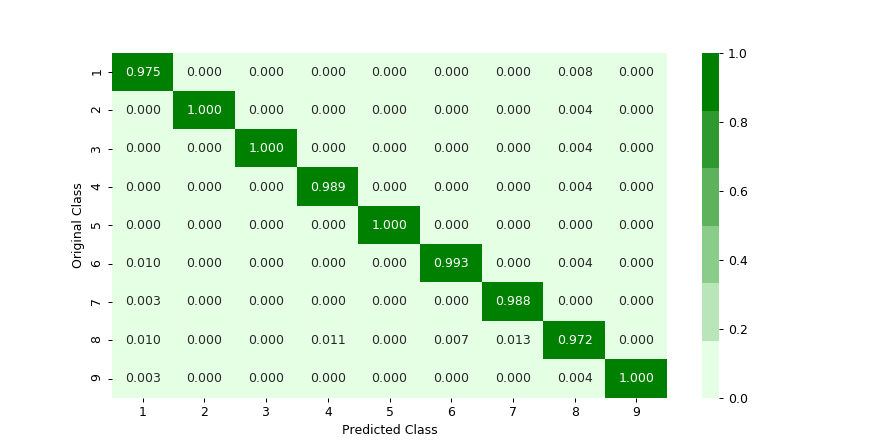

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


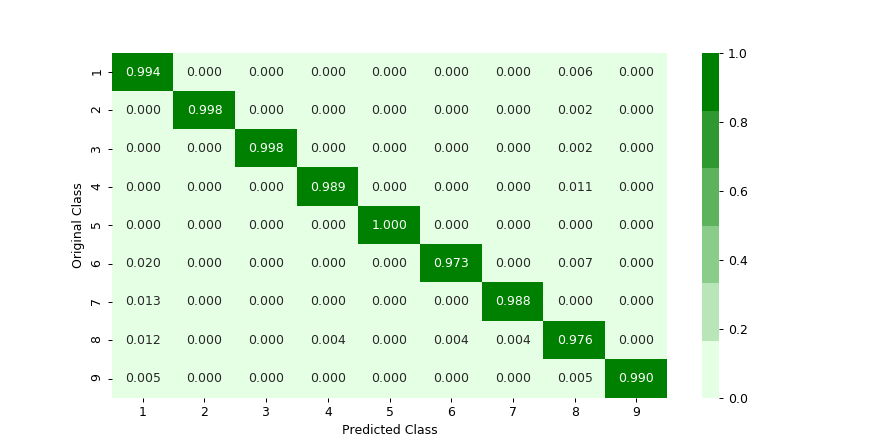

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [37]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.4 XgBoost Classifier</h3>

log_loss for c =  10 is 0.11588105338340265
log_loss for c =  50 is 0.057658250882591494
log_loss for c =  100 is 0.04186141305711363
log_loss for c =  500 is 0.03649854125696994
log_loss for c =  1000 is 0.035859619519393905
log_loss for c =  2000 is 0.03478236752207586
log_loss for c =  3000 is 0.033667303437409195


<IPython.core.display.Javascript object>


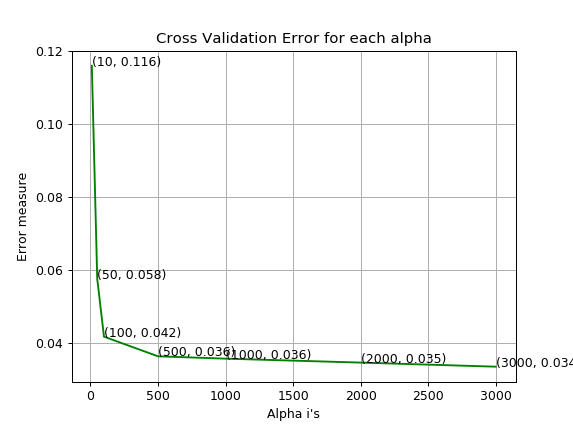

For values of best alpha =  3000 The train log loss is: 0.00982726018742022
For values of best alpha =  3000 The cross validation log loss is: 0.033667303437409195
For values of best alpha =  3000 The test log loss is: 0.042877055973511075
Number of misclassified points  0.78196872125115
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


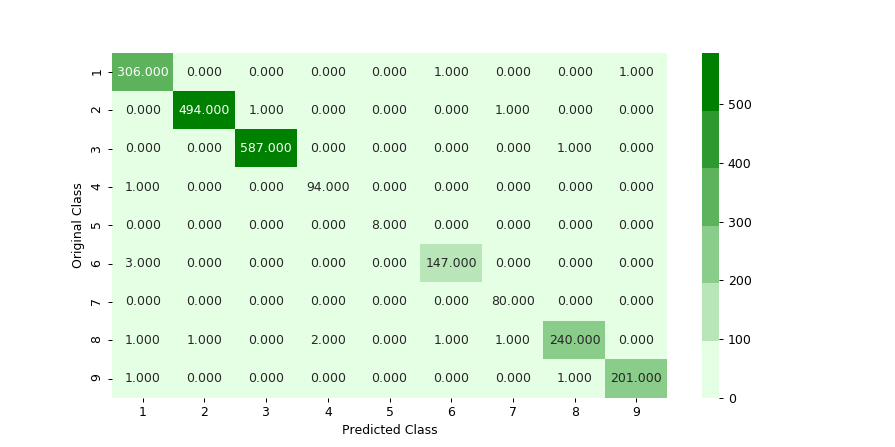

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


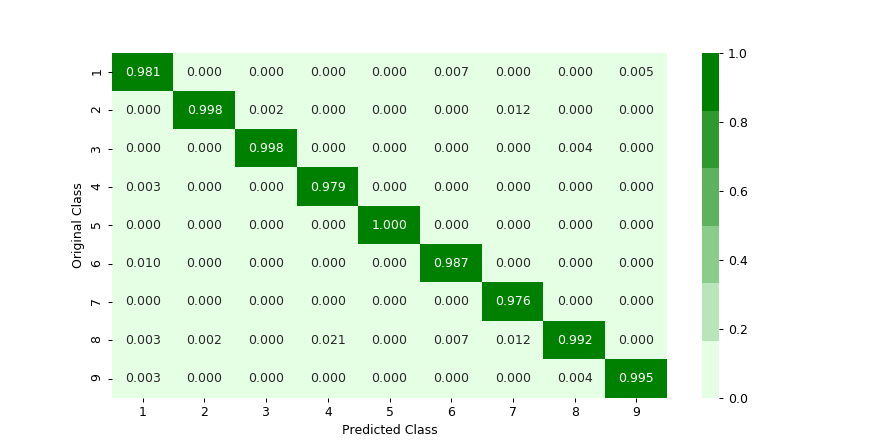

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


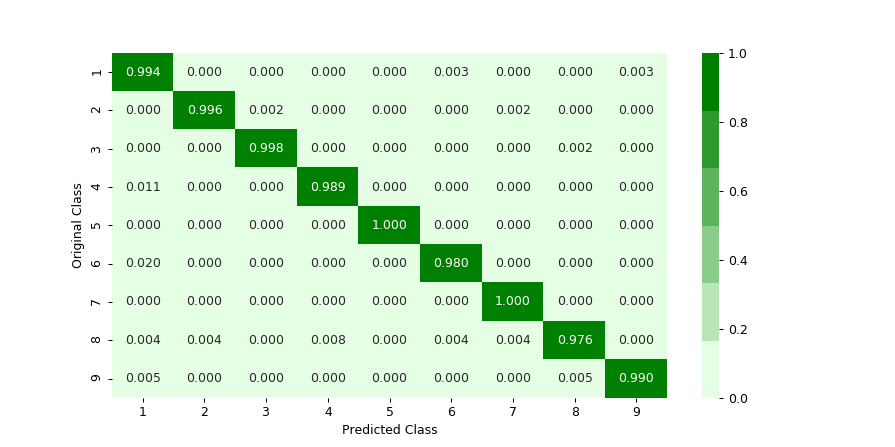

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [38]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data


alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.5 Xgboost Classifier with best hyperparameters</h3>

In [39]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_asm,y_train_asm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 15.6min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.7min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 500, 1000, 2000], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.1, 0.3, 0.5, 1], 'subsample': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [40]:
print (random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.5}


In [42]:
x_cfl=XGBClassifier(n_estimators=2000,subsample=0.5,learning_rate=0.01,colsample_bytree=0.5,max_depth=10)
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)
predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))

train loss 0.010626478719576738
cv loss 0.033016089856804966
test loss 0.04082419520278345


<h2> 4.5. Machine Learning models on features of both .asm and .bytes files</h2>

<h3> 4.5.1. Merging both asm and byte file features</h3>

In [21]:
result.head()

Unnamed: 0                    ID         0         1         2         3  \
0    0.000000  01azqd4InC7m9JpocGv5  0.262806  0.005498  0.001567  0.002067   
1    0.000092  01IsoiSMh5gxyDYTl4CB  0.017358  0.011737  0.004033  0.003876   
2    0.000184  01jsnpXSAlgw6aPeDxrU  0.040827  0.013434  0.001429  0.001315   
3    0.000276  01kcPWA9K2BOxQeS5Rju  0.009209  0.001708  0.000404  0.000441   
4    0.000368  01SuzwMJEIXsK7A8dQbl  0.008629  0.001000  0.000168  0.000234   

          4         5         6         7  ...          f9        fa  \
0  0.002048  0.001835  0.002058  0.002946  ...    0.013560  0.013107   
1  0.005303  0.003873  0.004747  0.006984  ...    0.001920  0.001147   
2  0.005464  0.005280  0.005078  0.002155  ...    0.009804  0.011777   
3  0.000770  0.000354  0.000310  0.000481  ...    0.002121  0.001886   
4  0.000342  0.000232  0.000148  0.000229  ...    0.001530  0.000853   

         fb        fc        fd        fe        ff        ??      size  Class  
0  0.013634  0.031724  0.014549  0.014348  0.007843  0.000129  0.092219      9  
1  0.001329  0.087867  0.002432  0.088411  0.074851  0.000606  0.121237      2  
2  0.012604  0.028423  0.013080  0.013937  0.067001  0.000033  0.084499      9  
3  0.002272  0.013032  0.002211  0.003957  0.010904  0.000984  0.010759      1  
4  0.001052  0.007511  0.001038  0.001258  0.002998  0.000636  0.006233      8  

[5 rows x 261 columns]

In [22]:
result_asm.head()

ID  HEADER:  .text:  .Pav:  .idata:  .data:  .bss:  \
0  01kcPWA9K2BOxQeS5Rju       19     744      0      127      57      0   
1  1E93CpP60RHFNiT5Qfvn       17     838      0      103      49      0   
2  3ekVow2ajZHbTnBcsDfX       17     427      0       50      43      0   
3  3X2nY7iQaPBIWDrAZqJe       17     227      0       43      19      0   
4  46OZzdsSKDCFV8h7XWxf       17     402      0       59     170      0   

   .rdata:  .edata:  .rsrc:    ...     esi  eax  ebx  ecx  edi  ebp  esp  eip  \
0      323        0       3    ...      66   15   43   83    0   17   48   29   
1        0        0       3    ...      29   48   82   12    0   14    0   20   
2      145        0       3    ...      42   10   67   14    0   11    0    9   
3        0        0       3    ...       8   14    7    2    0    8    0    6   
4        0        0       3    ...       9   18   29    5    0   11    0   11   

   Class      size  
0      1  0.078190  
1      1  0.063400  
2      1  0.041695  
3      1  0.018757  
4      1  0.037567  

[5 rows x 54 columns]

In [23]:
print(result.shape)
print(result_asm.shape)

(10868, 261)
(10868, 54)


In [24]:
result_x = pd.merge(result,result_asm.drop(['Class'], axis=1),on='ID', how='left')
result_y = result_x['Class']
result_x = result_x.drop(['ID','rtn','.BSS:','.CODE','Class'], axis=1)
result_x.head()

Unnamed: 0         0         1         2         3         4         5  \
0    0.000000  0.262806  0.005498  0.001567  0.002067  0.002048  0.001835   
1    0.000092  0.017358  0.011737  0.004033  0.003876  0.005303  0.003873   
2    0.000184  0.040827  0.013434  0.001429  0.001315  0.005464  0.005280   
3    0.000276  0.009209  0.001708  0.000404  0.000441  0.000770  0.000354   
4    0.000368  0.008629  0.001000  0.000168  0.000234  0.000342  0.000232   

          6         7         8    ...      edx   esi   eax   ebx  ecx  edi  \
0  0.002058  0.002946  0.002638    ...      808  2290  1281   587  701    0   
1  0.004747  0.006984  0.008267    ...      260  1090   391   905  420    0   
2  0.005078  0.002155  0.008104    ...        5   547     5   451   56    0   
3  0.000310  0.000481  0.000959    ...       18    66    15    43   83    0   
4  0.000148  0.000229  0.000376    ...       18  1228    24  1546  107    0   

   ebp  esp  eip     size_y  
0   15   14  456  56.229886  
1   24   22  227  13.999378  
2   27    0  117   8.507785  
3   17   48   29   0.078190  
4   15    0   76   0.996723  

[5 rows x 308 columns]

In [25]:
result_y.head()

0    9
1    2
2    9
3    1
4    8
Name: Class, dtype: int64

<h3> 4.5.2. Multivariate Analysis on final fearures</h3>

<IPython.core.display.Javascript object>


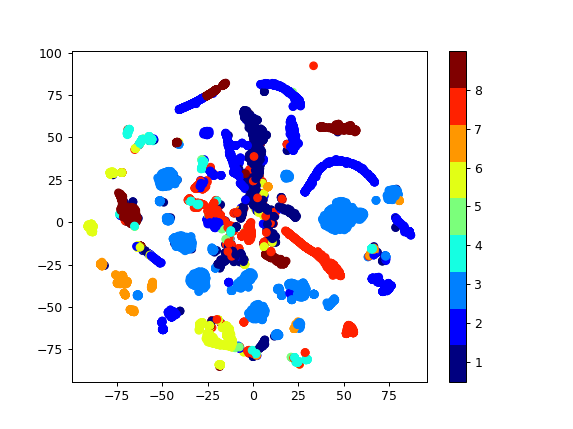

In [25]:
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_x)
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=result_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(9))
plt.clim(0.5, 9)
plt.show()

<h3> 4.5.3. Train and Test split</h3>

In [26]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

<h3> 4.5.4. Random Forest Classifier on final features</h3>

log_loss for c =  10 is 0.058864988008900165
log_loss for c =  50 is 0.04982171352389583
log_loss for c =  100 is 0.04877439563993806
log_loss for c =  500 is 0.04633136949419593
log_loss for c =  1000 is 0.04633282669842955
log_loss for c =  2000 is 0.04666148931304081
log_loss for c =  3000 is 0.04684161733430787


<IPython.core.display.Javascript object>


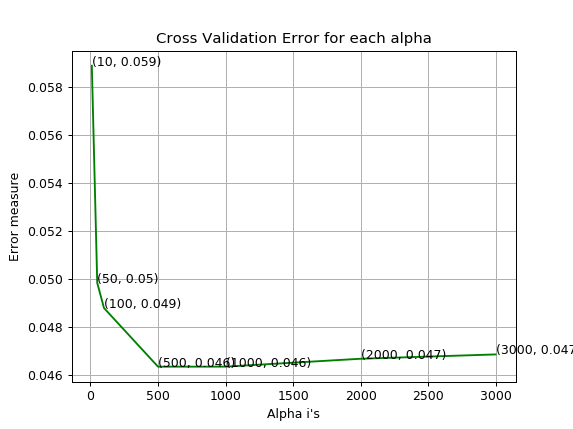

For values of best alpha =  500 The train log loss is: 0.015045746557915482
For values of best alpha =  500 The cross validation log loss is: 0.04633136949419593
For values of best alpha =  500 The test log loss is: 0.0419437056294099


In [34]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_merge,y_train_merge)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

<h3> 4.5.5. XgBoost Classifier on final features</h3>

log_loss for c =  10 is 0.08634410259197668
log_loss for c =  50 is 0.0467962200270487
log_loss for c =  100 is 0.03846464669244138
log_loss for c =  500 is 0.03542509345482663
log_loss for c =  1000 is 0.03524790113745623
log_loss for c =  2000 is 0.03537820448736872
log_loss for c =  3000 is 0.035384159245550155


<IPython.core.display.Javascript object>


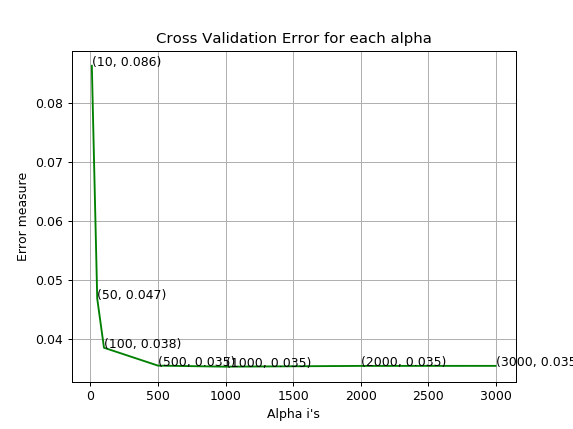

For values of best alpha =  1000 The train log loss is: 0.010771162453744454
For values of best alpha =  1000 The cross validation log loss is: 0.035384159245550155
For values of best alpha =  1000 The test log loss is: 0.024834218493213808


In [35]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=3000,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

<h3> 4.5.5. XgBoost Classifier on final features with best hyper parameters using Random search</h3>

In [36]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_merge, y_train_merge)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 28.6min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 37.0min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 500, 1000, 2000], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.1, 0.3, 0.5, 1], 'subsample': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [37]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


For values of best alpha =  1000 The train log loss is: 0.010849938040281054
For values of best alpha =  1000 The cross validation log loss is: 0.03269108838914283
For values of best alpha =  1000 The test log loss is: 0.02814277993749233
Number of misclassified points  81.73873045078197
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


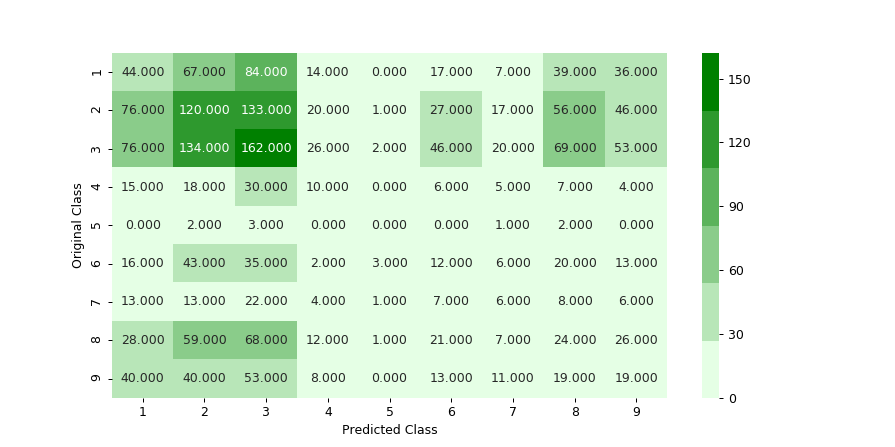

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


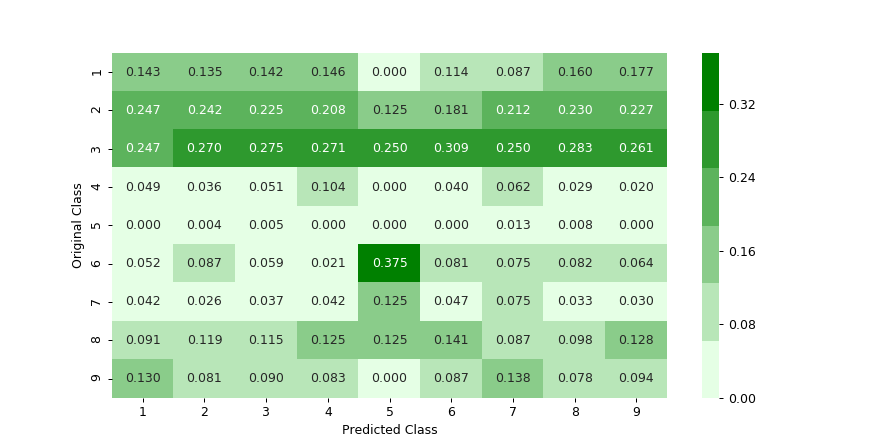

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


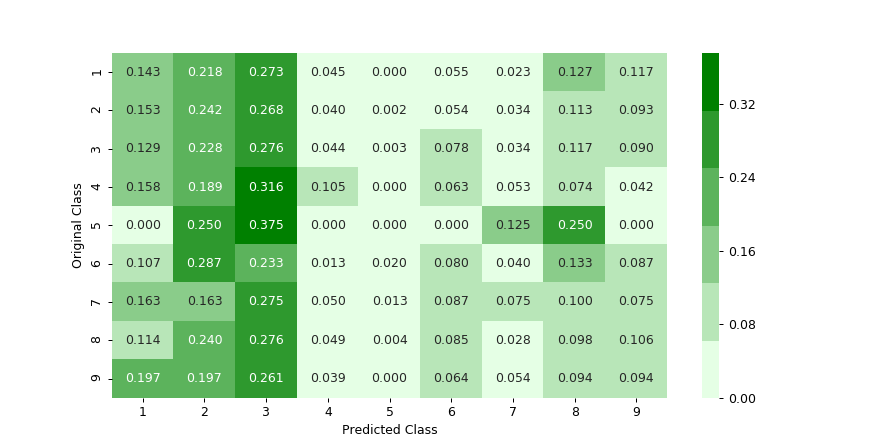

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=1000,max_depth=5,learning_rate=0.1,colsample_bytree=0.5,subsample=1,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
    
predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_merge))

# byte features

In [25]:
result_x['ID'] = result.ID

In [23]:
byte_vocab = "00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

In [29]:
def byte_bigram():    
    byte_bigram_vocab = []
    for i, v in enumerate(byte_vocab.split(',')):
        for j in range(0, len(byte_vocab.split(','))):
            byte_bigram_vocab.append(v + ' ' +byte_vocab.split(',')[j])
    len(byte_bigram_vocab)

In [26]:
byte_bigram()

66049

In [27]:
byte_bigram_vocab[:5]

['00 00', '00 01', '00 02', '00 03', '00 04']

In [30]:
def byte_trigram():
    byte_trigram_vocab = []
    for i, v in enumerate(byte_vocab.split(',')):
        for j in range(0, len(byte_vocab.split(','))):
            for k in range(0, len(byte_vocab.split(','))):
                byte_trigram_vocab.append(v + ' ' +byte_vocab.split(',')[j]+' '+byte_vocab.split(',')[k])
    len(byte_trigram_vocab)

In [6]:
byte_trigram()

16974593

In [7]:
byte_trigram_vocab[:5]

['00 00 00', '00 00 01', '00 00 02', '00 00 03', '00 00 04']

In [28]:
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=byte_bigram_vocab)
bytebigram_vect = scipy.sparse.csr_matrix((10868, 66049))
for i, file in tqdm(enumerate(os.listdir('byteFiles'))):
    f = open('byteFiles/' + file)
    a[i:]+= scipy.sparse.csr_matrix(vect.fit_transform([f.read().replace('\n', ' ').lower()]))
    f.close()

10868it [3:49:23,  2.10it/s]


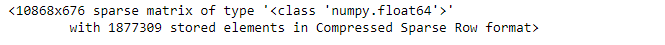

In [44]:
bytebigram_vect

In [43]:
scipy.sparse.save_npz('bytebigram.npz', bytebigram_vect)

In [30]:
from sklearn.preprocessing import normalize
byte_bigram_vect = normalize(scipy.sparse.load_npz('bytebigram.npz'), axis = 0)


# N-Gram(2-Gram, 3-Gram, 4-Gram) Opcode Vectorization

In [31]:
opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

In [31]:
def asmopcodebigram():
    asmopcodebigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            asmopcodebigram.append(v + ' ' + opcodes[j])
    len(asmopcodebigram)

In [32]:
asmopcodebigram

676

In [33]:
def asmopcodetrigram():
    asmopcodetrigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            for k in range(0, len(opcodes)):
                asmopcodetrigram.append(v + ' ' + opcodes[j] + ' ' + opcodes[k])
    len(asmopcodetrigram)

In [33]:
asmopcodetrigram

17576

In [34]:
def asmopcodetetragram():
    asmopcodetetragram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            for k in range(0, len(opcodes)):
                for l in range(0, len(opcodes)):
                    asmopcodetetragram.append(v + ' ' + opcodes[j] + ' ' + opcodes[k] + ' ' + opcodes[l])
    len(asmopcodetetragram)

In [34]:
asmopcodetetragram

456976

In [ ]:
def opcode_collect():
    op_file = open("opcode_file.txt", "w+")
    for asmfile in os.listdir('asmFiles'):
        opcode_str = ""
        with codecs.open('asmFiles/' + asmfile, encoding='cp1252', errors ='replace') as fli:
            for lines in fli:
                line = lines.rstrip().split()            
                for li in line:
                    if li in opcodes:
                        opcode_str += li + ' '
        op_file.write(opcode_str + "\n")
    op_file.close()
opcode_collect()

In [47]:
vect = CountVectorizer(ngram_range=(2, 2), vocabulary = asmopcodebigram)
opcodebivect = scipy.sparse.csr_matrix((10868, len(asmopcodebigram)))
raw_opcode = open('opcode_file.txt').read().split('\n')

for indx in range(10868):
    opcodebivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [48]:
opcodebivect

<10868x676 sparse matrix of type '<class 'numpy.float64'>'
	with 1877309 stored elements in Compressed Sparse Row format>

In [49]:
scipy.sparse.save_npz('opcodebigram.npz', opcodebivect)

In [51]:
vect = CountVectorizer(ngram_range=(3, 3), vocabulary = asmopcodetrigram)
opcodetrivect = scipy.sparse.csr_matrix((10868, len(asmopcodetrigram)))

for indx in range(10868):
    opcodetrivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [52]:
opcodetrivect

<10868x17576 sparse matrix of type '<class 'numpy.float64'>'
	with 7332672 stored elements in Compressed Sparse Row format>

In [53]:
scipy.sparse.save_npz('opcodetrigram.npz', opcodetrivect)

In [54]:
vect = CountVectorizer(ngram_range=(4, 4), vocabulary = asmopcodetetragram)
opcodetetravect = scipy.sparse.csr_matrix((10868, len(asmopcodetetragram)))

for indx in range(10868):
    opcodetetravect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [55]:
opcodetetravect

<10868x456976 sparse matrix of type '<class 'numpy.float64'>'
	with 16605229 stored elements in Compressed Sparse Row format>

In [56]:
scipy.sparse.save_npz('opcodetetragram.npz', opcodetetravect)

In [35]:
opcodetetravect = scipy.sparse.load_npz('opcodetetragram.npz')

In [36]:
opcodetrivect=scipy.sparse.load_npz('opcodetrigram.npz')

In [37]:
opcodebivect=scipy.sparse.load_npz('opcodebigram.npz')

# Image Feature Extraction From ASM Files

In [35]:
import array

In [64]:
def collect_img_asm():
    for asmfile in os.listdir("asmFiles"):
        filename = asmfile.split('.')[0]
        file = codecs.open("asmFiles/" + asmfile, 'rb')
        filelen = os.path.getsize("asmFiles/" + asmfile)
        width = int(filelen ** 0.5)
        rem = int(filelen / width)
        arr = array.array('B')
        arr.frombytes(file.read())
        file.close()
        reshaped = np.reshape(arr[:width * width], (width, width))
        reshaped = np.uint8(reshaped)
        scipy.misc.imsave('asm_image/' + filename + '.png',reshaped)

In [65]:
collect_img_asm()

# First 200 Image Pixels

In [38]:
import cv2
imagefeatures = np.zeros((10868, 200))

In [67]:
for i, asmfile in enumerate(os.listdir("asmFiles")):
    img = cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    img_arr = img.flatten()[:200]
    imagefeatures[i, :] += img_arr

In [68]:
imgfeatures_name = []
for i in range(200):
    img_features_name.append('pix' + str(i))
imgdf = pd.DataFrame(normalize(imagefeatures, axis = 0), columns = imgfeatures_name)

In [69]:
imgdf['ID'] = result.ID

In [70]:
imgdf.head()

pix0      pix1      pix2      pix3      pix4      pix5      pix6  \
0  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   
1  0.006560  0.006560  0.006560  0.013504  0.013504  0.013504  0.012927   
2  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   
3  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   
4  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   

       pix7      pix8      pix9          ...             pix191    pix192  \
0  0.008320  0.008320  0.007913          ...           0.009593  0.009593   
1  0.012927  0.012927  0.013963          ...           0.009593  0.009593   
2  0.008320  0.008320  0.007913          ...           0.009593  0.009593   
3  0.008320  0.008320  0.007913          ...           0.009593  0.009593   
4  0.008320  0.008320  0.007913          ...           0.009593  0.009593   

     pix193    pix194    pix195    pix196    pix197    pix198    pix199  \
0  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
1  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
2  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
3  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
4  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   

                     ID  
0  01azqd4InC7m9JpocGv5  
1  01IsoiSMh5gxyDYTl4CB  
2  01jsnpXSAlgw6aPeDxrU  
3  01kcPWA9K2BOxQeS5Rju  
4  01SuzwMJEIXsK7A8dQbl  

[5 rows x 201 columns]

In [71]:
joblib.dump(imgdf, 'img_df')

['img_df']

In [72]:
img_df=joblib.load('img_df')

In [73]:
img_df.head()

pix0      pix1      pix2      pix3      pix4      pix5      pix6  \
0  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   
1  0.006560  0.006560  0.006560  0.013504  0.013504  0.013504  0.012927   
2  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   
3  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   
4  0.010268  0.010268  0.010268  0.008033  0.008033  0.008033  0.008320   

       pix7      pix8      pix9          ...             pix191    pix192  \
0  0.008320  0.008320  0.007913          ...           0.009593  0.009593   
1  0.012927  0.012927  0.013963          ...           0.009593  0.009593   
2  0.008320  0.008320  0.007913          ...           0.009593  0.009593   
3  0.008320  0.008320  0.007913          ...           0.009593  0.009593   
4  0.008320  0.008320  0.007913          ...           0.009593  0.009593   

     pix193    pix194    pix195    pix196    pix197    pix198    pix199  \
0  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
1  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
2  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
3  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   
4  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593   

                     ID  
0  01azqd4InC7m9JpocGv5  
1  01IsoiSMh5gxyDYTl4CB  
2  01jsnpXSAlgw6aPeDxrU  
3  01kcPWA9K2BOxQeS5Rju  
4  01SuzwMJEIXsK7A8dQbl  

[5 rows x 201 columns]

# Important Feature Selection Using Random Forest

In [38]:
def imp_features(data, features, keep):
    rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
    rf.fit(data, result_y)
    imp_feature_indx = np.argsort(rf.feature_importances_)[::-1]
    imp_value = np.take(rf.feature_importances_, imp_feature_indx[:20])
    imp_feature_name = np.take(features, imp_feature_indx[:20])
    sns.set()
    plt.figure(figsize = (10, 5))
    ax = sns.barplot(x = imp_feature_name, y = imp_value)
    ax.set_xticklabels(labels = imp_feature_name, rotation = 45)
    sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
    plt.title('Important Features')
    plt.xlabel('Feature Names')
    plt.ylabel('Importance')
    return imp_feature_indx[:keep]

# Important Feature Among Opcode Bi-Gram

In [44]:
op_bi_indxes = imp_features(normalize(opcodebivect, axis = 0), asmopcodebigram, 200)

In [45]:
op_bi_df = pd.SparseDataFrame(normalize(opcodebivect, axis = 0), columns = asmopcodebigram)
for col in op_bi_df.columns:
    if col not in np.take(asmopcodebigram, op_bi_indxes):
        op_bi_df.drop(col, axis = 1, inplace = True)

In [46]:
op_bi_df.to_dense().to_csv('op_bi.csv')

In [47]:
op_bi_df = pd.read_csv('op_bi.csv').drop('Unnamed: 0', axis = 1).fillna(0)

In [48]:
op_bi_df['ID'] = result.ID
op_bi_df.head()

jmp jmp   jmp mov  jmp retf  jmp push   jmp pop   jmp xor  jmp sub  \
0  0.031815  0.003894  0.000000   0.00042  0.000000  0.002374  0.00895   
1  0.000000  0.000649  0.000000   0.00021  0.000374  0.000419  0.00000   
2  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000  0.00000   
3  0.000000  0.000101  0.000000   0.00007  0.000000  0.000279  0.00000   
4  0.000362  0.001156  0.001467   0.00028  0.000374  0.000140  0.00000   

    jmp dec   jmp add   jmp cmp          ...           movzx jmp  movzx mov  \
0  0.001268  0.016752  0.000112          ...                 0.0   0.000000   
1  0.000000  0.001971  0.000000          ...                 0.0   0.002315   
2  0.000000  0.000000  0.000000          ...                 0.0   0.000000   
3  0.000000  0.000000  0.000000          ...                 0.0   0.000000   
4  0.000000  0.000000  0.000112          ...                 0.0   0.000220   

   movzx push  movzx xor  movzx sub  movzx or  movzx cmp  movzx lea  \
0    0.000000   0.000000   0.000000  0.000000   0.000000   0.000000   
1    0.000344   0.000000   0.001884  0.004541   0.000471   0.000000   
2    0.005852   0.005032   0.001884  0.009839   0.005648   0.009469   
3    0.000000   0.000162   0.000000  0.000000   0.000000   0.000000   
4    0.000000   0.000487   0.000235  0.001514   0.005177   0.000000   

   movzx movzx                    ID  
0     0.000000  01azqd4InC7m9JpocGv5  
1     0.000000  01IsoiSMh5gxyDYTl4CB  
2     0.001869  01jsnpXSAlgw6aPeDxrU  
3     0.000000  01kcPWA9K2BOxQeS5Rju  
4     0.000623  01SuzwMJEIXsK7A8dQbl  

[5 rows x 201 columns]

# Important Feature Among Opcode 3-Gram

In [39]:
op_tri_indxes = imp_features(normalize(opcodetrivect, axis = 0), asmopcodetrigram, 200)

In [40]:
op_tri_df = pd.SparseDataFrame(normalize(opcodetrivect, axis = 0), columns = asmopcodetrigram)
op_tri_df = op_tri_df.loc[:, np.intersect1d(op_tri_df.columns, np.take(asmopcodetrigram, op_tri_indxes))]

In [41]:
op_tri_df.to_dense().to_csv('op_tri.csv')

In [42]:
op_tri_df = pd.read_csv('op_tri.csv').drop('Unnamed: 0', axis = 1).fillna(0)

In [43]:
op_tri_df['ID'] = result.ID
op_tri_df.head()

add cmp jmp  add mov add  add mov cmp  add mov jmp  add mov mov  \
0     0.000000     0.002183     0.001340     0.001563     0.003593   
1     0.000000     0.001364     0.000670     0.000625     0.002705   
2     0.000000     0.000000     0.000000     0.000000     0.000000   
3     0.000000     0.000000     0.000000     0.000000     0.000000   
4     0.001292     0.001091     0.004914     0.002814     0.014009   

   add pop call  add pop mov  add pop pop  add pop push  add pop retn  \
0           0.0     0.005354     0.000342      0.000000       0.00084   
1           0.0     0.001785     0.000000      0.000000       0.00028   
2           0.0     0.000000     0.000000      0.000000       0.00000   
3           0.0     0.000000     0.000000      0.000000       0.00000   
4           0.0     0.000000     0.000000      0.000441       0.00000   

           ...           sub push push  sub retn push  sub shl push  \
0          ...                0.006742       0.006907      0.042017   
1          ...                0.001556       0.000000      0.000000   
2          ...                0.001383       0.017267      0.000000   
3          ...                0.000000       0.000000      0.000000   
4          ...                0.000000       0.000000      0.000000   

   sub xor mov  xor inc shl  xor lea or  xor mov mov  xor pop pop  \
0     0.017119          0.0    0.007679     0.001768     0.000391   
1     0.000000          0.0    0.000000     0.001667     0.000391   
2     0.000000          0.0    0.015359     0.000000     0.000000   
3     0.000000          0.0    0.000000     0.000051     0.000000   
4     0.000000          0.0    0.000000     0.000202     0.000000   

   xor pop push                    ID  
0           0.0  01azqd4InC7m9JpocGv5  
1           0.0  01IsoiSMh5gxyDYTl4CB  
2           0.0  01jsnpXSAlgw6aPeDxrU  
3           0.0  01kcPWA9K2BOxQeS5Rju  
4           0.0  01SuzwMJEIXsK7A8dQbl  

[5 rows x 201 columns]

# Important Feature Among Opcode 4-Gram

In [49]:
op_tetra_indxes = imp_features(normalize(opcodetetravect, axis = 0), asmopcodetetragram, 200)

In [50]:
op_tetra_df = pd.SparseDataFrame(normalize(opcodetetravect, axis = 0), columns = asmopcodetetragram)
op_tetra_df = op_tetra_df.loc[:, np.intersect1d(op_tetra_df.columns, np.take(asmopcodetetragram, op_tetra_indxes))]



In [51]:
op_tetra_df.to_dense().to_csv('op_tetra.csv')

In [52]:
op_tetra_df = pd.read_csv('op_tetra.csv').drop('Unnamed: 0', axis = 1).fillna(0)

In [53]:
op_tetra_df['ID'] = result.ID
op_tetra_df.head()

add mov add mov  add mov add pop  add mov cmp jnb  add mov mov add  \
0         0.001593         0.007668         0.000000         0.002031   
1         0.000000         0.007668         0.000000         0.001625   
2         0.000000         0.000000         0.000000         0.000000   
3         0.000000         0.000000         0.000000         0.000000   
4         0.002125         0.000000         0.023352         0.023558   

   add mov mov mov  add pop mov push  add pop pop pop  add pop push call  \
0         0.002517               0.0              0.0                0.0   
1         0.002760               0.0              0.0                0.0   
2         0.000000               0.0              0.0                0.0   
3         0.000000               0.0              0.0                0.0   
4         0.006657               0.0              0.0                0.0   

   add retn push push  call add mov sub          ...           \
0             0.00116          0.000000          ...            
1             0.00000          0.000000          ...            
2             0.00000          0.000000          ...            
3             0.00000          0.000000          ...            
4             0.00000          0.009682          ...            

   xor cmp cmp jnb  xor cmp inc cmp  xor lea or mov  xor mov inc mov  \
0              0.0              0.0             0.0              0.0   
1              0.0              0.0             0.0              0.0   
2              0.0              0.0             0.0              0.0   
3              0.0              0.0             0.0              0.0   
4              0.0              0.0             0.0              0.0   

   xor pop call retn  xor push push push  xor retn mov push  xor sub inc shl  \
0                0.0            0.000525                0.0              0.0   
1                0.0            0.000000                0.0              0.0   
2                0.0            0.003677                0.0              0.0   
3                0.0            0.000000                0.0              0.0   
4                0.0            0.000000                0.0              0.0   

   xor xor cmp inc                    ID  
0              0.0  01azqd4InC7m9JpocGv5  
1              0.0  01IsoiSMh5gxyDYTl4CB  
2              0.0  01jsnpXSAlgw6aPeDxrU  
3              0.0  01kcPWA9K2BOxQeS5Rju  
4              0.0  01SuzwMJEIXsK7A8dQbl  

[5 rows x 201 columns]

# Important Feature Among Byte Bi-Gram

In [54]:
byte_bi_indxes = imp_features(normalize(bytebigram_vect, axis = 0), byte_bigram_vocab, 300)

In [55]:
np.save('byte_bi_indx', byte_bi_indxes)

In [56]:
byte_bi_indxes = np.load('byte_bi_indx.npy')

In [57]:
top_byte_bi = np.zeros((10868, 0))
for i in byte_bi_indxes:
    sliced = bytebigram_vect[:, i].todense()
    top_byte_bi = np.hstack([top_byte_bi, sliced])

In [58]:
byte_bi_df = pd.SparseDataFrame(top_byte_bi, columns = np.take(byte_bigram_vocab, byte_bi_indxes))

In [59]:
byte_bi_df.to_dense().to_csv('byte_bi.csv')

In [60]:
byte_bi_df = pd.read_csv('byte_bi.csv').drop('Unnamed: 0', axis = 1).fillna(0)

In [61]:
byte_bi_df['ID'] = result.ID


In [62]:
byte_bi_df.head()

?? ??  55 95  55 b3  55 b2  55 b1  55 b0  55 af  55 ae  55 ad  55 ac  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

           ...           54 b3  54 b4  54 c4  54 d1  54 d0  54 cf  54 ce  \
0          ...             0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1          ...             0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2          ...             0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3          ...             0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4          ...             0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   54 cd  54 cc                    ID  
0    0.0    0.0  01azqd4InC7m9JpocGv5  
1    0.0    0.0  01IsoiSMh5gxyDYTl4CB  
2    0.0    0.0  01jsnpXSAlgw6aPeDxrU  
3    0.0    0.0  01kcPWA9K2BOxQeS5Rju  
4    0.0    0.0  01SuzwMJEIXsK7A8dQbl  

[5 rows x 301 columns]

# Advanced features 

## Adding 300 bytebigram,200 opcode bigram,200 opcode trigram,200 opcode tetragram ,first 200 image pixels

In [74]:
final_data = pd.concat([result_x, op_bi_df, op_tri_df, op_tetra_df, byte_bi_df,img_df], axis = 1, join = 'inner')

In [75]:
final_data = final_data.drop('ID', axis = 1)

In [76]:
final_data.head()

Unnamed: 0         0         1         2         3         4         5  \
0    0.000000  0.262806  0.005498  0.001567  0.002067  0.002048  0.001835   
1    0.000092  0.017358  0.011737  0.004033  0.003876  0.005303  0.003873   
2    0.000184  0.040827  0.013434  0.001429  0.001315  0.005464  0.005280   
3    0.000276  0.009209  0.001708  0.000404  0.000441  0.000770  0.000354   
4    0.000368  0.008629  0.001000  0.000168  0.000234  0.000342  0.000232   

          6         7         8    ...       pix190    pix191    pix192  \
0  0.002058  0.002946  0.002638    ...     0.009593  0.009593  0.009593   
1  0.004747  0.006984  0.008267    ...     0.009593  0.009593  0.009593   
2  0.005078  0.002155  0.008104    ...     0.009593  0.009593  0.009593   
3  0.000310  0.000481  0.000959    ...     0.009593  0.009593  0.009593   
4  0.000148  0.000229  0.000376    ...     0.009593  0.009593  0.009593   

     pix193    pix194    pix195    pix196    pix197    pix198    pix199  
0  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  
1  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  
2  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  
3  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  
4  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  0.009593  

[5 rows x 1408 columns]

In [77]:
final_data.to_csv('final_data.csv')


In [27]:
final_data = pd.read_csv('final_data.csv')

In [37]:
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(final_data, result_y, stratify = result_y, test_size = 0.20)
x_trn_final, x_cv_final, y_trn_final, y_cv_final = train_test_split(x_train_final, y_train_final, stratify = y_train_final, test_size = 0.20)

# Machine Learning Models on ASM Features + Byte Features + Advanced Features

log_loss for c =  1e-05 is 1.1840039867727614
log_loss for c =  0.0001 is 1.1217881098745714
log_loss for c =  0.001 is 1.174936322460997
log_loss for c =  0.01 is 1.0741224260174453
log_loss for c =  0.1 is 1.1761396828975654
log_loss for c =  1 is 1.2362570810343723
log_loss for c =  10 is 1.1804717850739066
log_loss for c =  100 is 1.1684083137157295
log_loss for c =  1000 is 1.1061521197568476


<IPython.core.display.Javascript object>


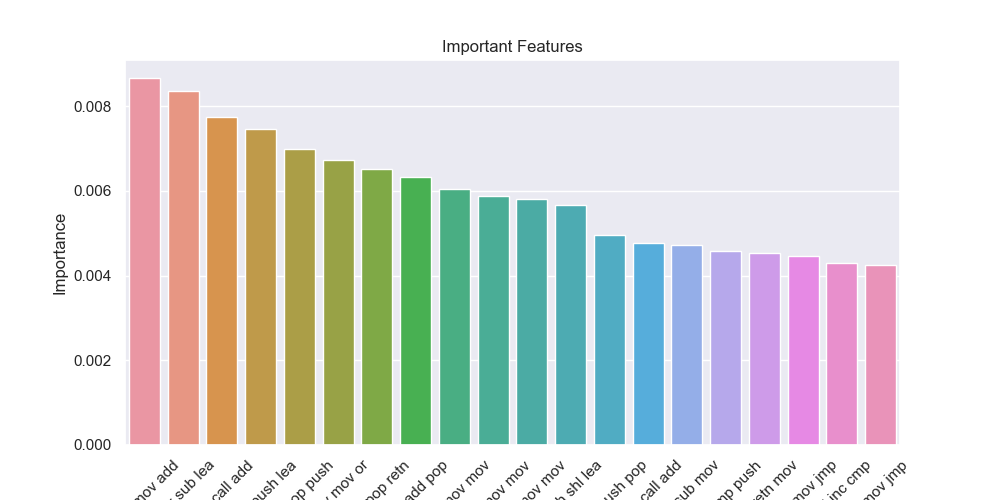

<IPython.core.display.Javascript object>


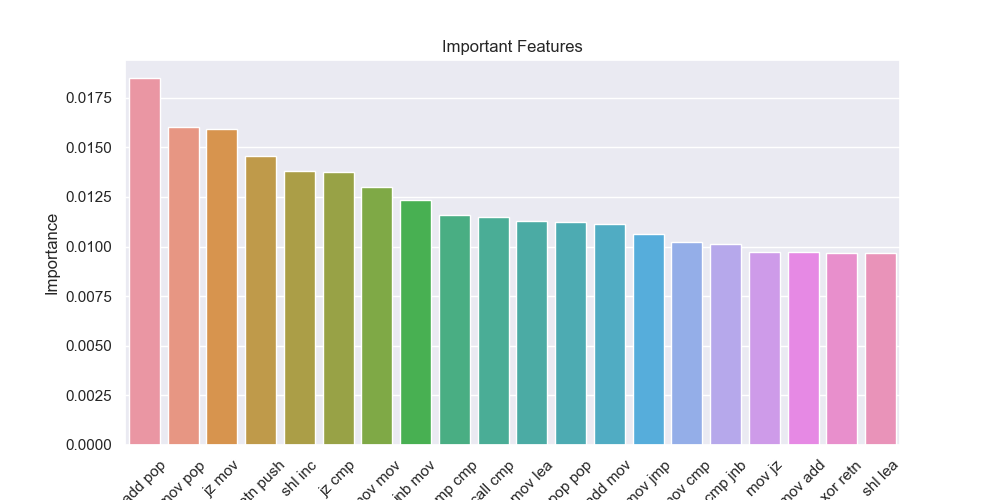

<IPython.core.display.Javascript object>


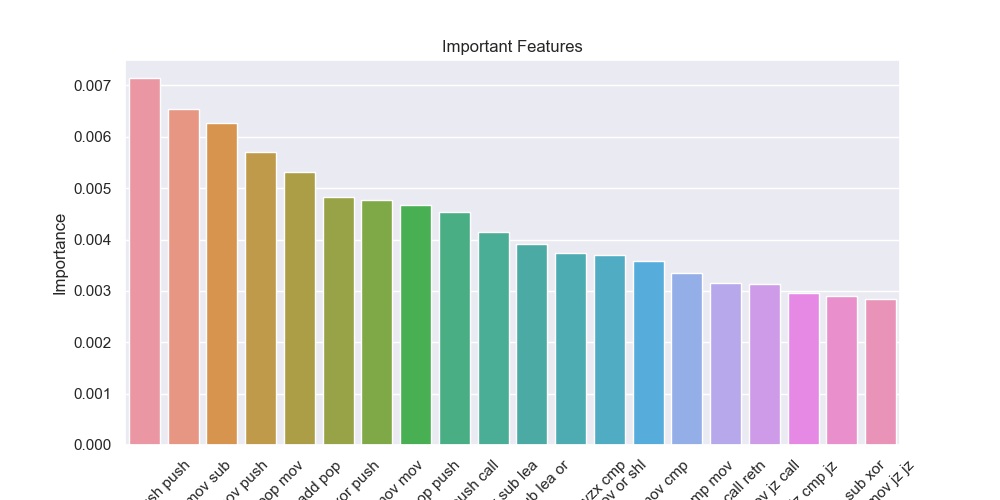

<IPython.core.display.Javascript object>


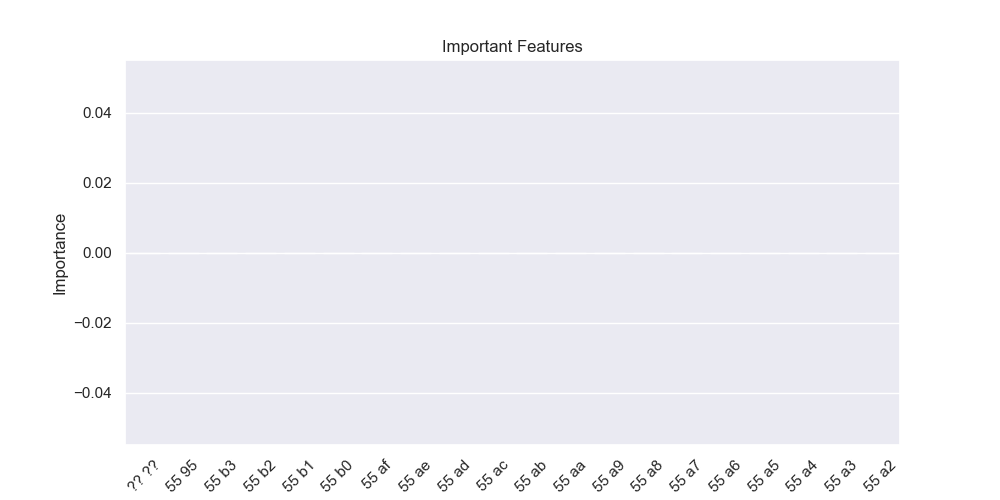

<IPython.core.display.Javascript object>


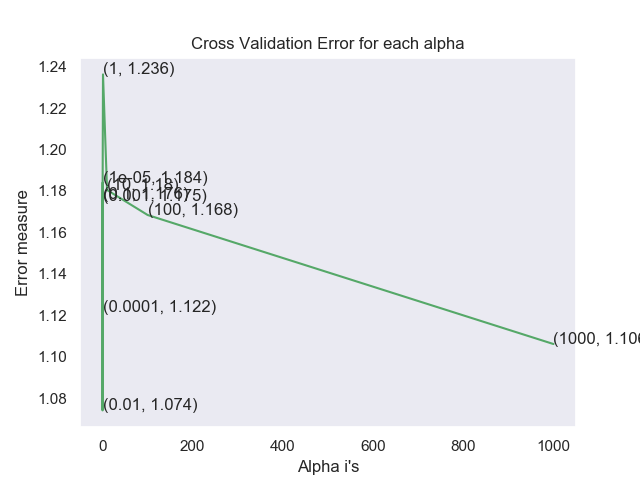

In [80]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(x_trn_final,y_trn_final)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(x_trn_final,y_trn_final)
    predict_y = sig_clf.predict_proba(x_cv_final)
    cv_log_error_array.append(log_loss(y_cv_final, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



In [35]:
logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(x_trn_final,y_trn_final)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(x_trn_final,y_trn_final)

predict_y = sig_clf.predict_proba(x_trn_final)
print ('log loss for train data',(log_loss(y_trn_final, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(x_cv_final)
print ('log loss for cv data',(log_loss(y_cv_final, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(x_test_final)
print ('log loss for test data',(log_loss(y_test_final, predict_y, labels=logisticR.classes_, eps=1e-15)))

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


log loss for train data 1.193174530266704
log loss for cv data 1.1785070578048291
log loss for test data 1.2060464393477006


Number of misclassified points  31.324747010119598
-------------------------------------------------- Confusion matrix --------------------------------------------------


<IPython.core.display.Javascript object>


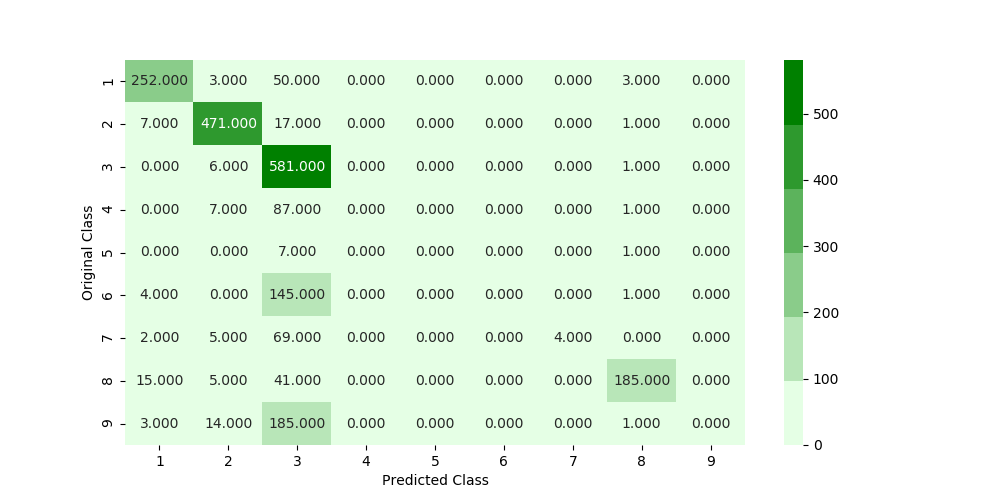

-------------------------------------------------- Precision matrix --------------------------------------------------


<IPython.core.display.Javascript object>


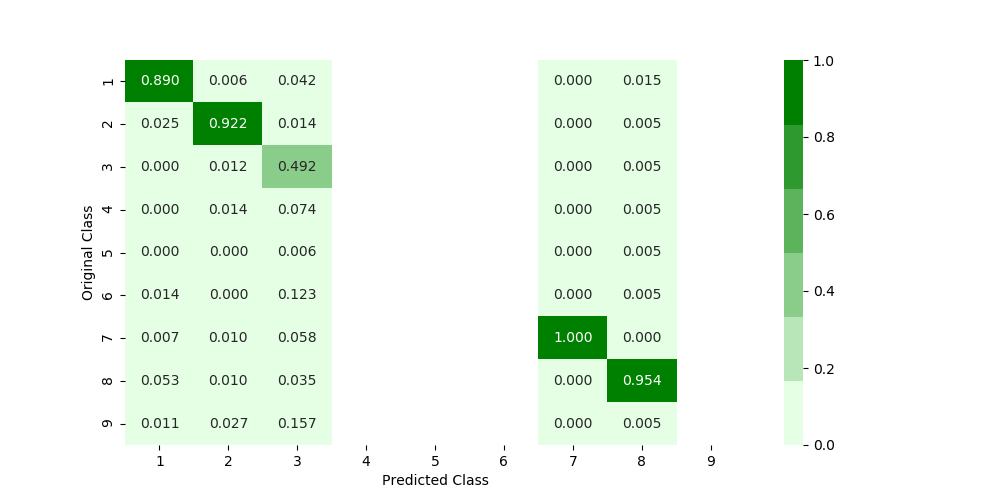

Sum of columns in precision matrix [ 1.  1.  1. nan nan nan  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


<IPython.core.display.Javascript object>


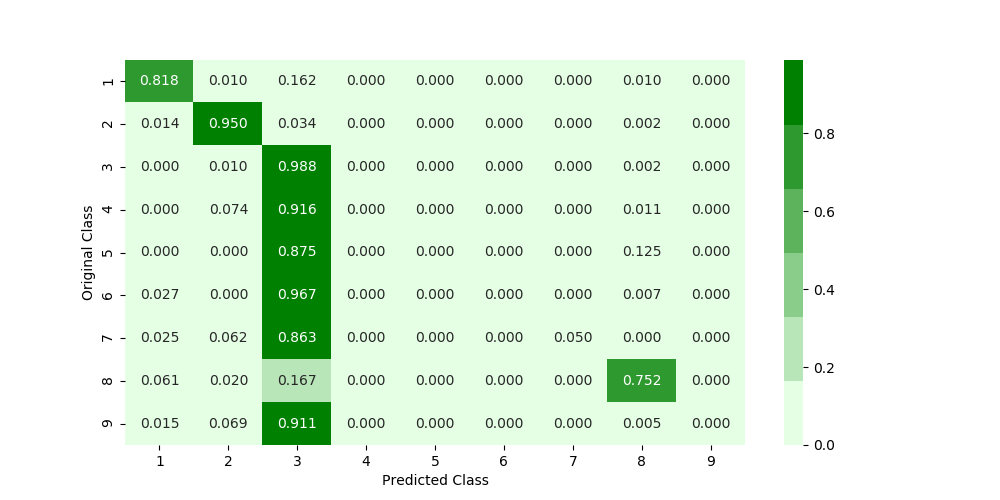

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
plot_confusion_matrix(y_test_final,sig_clf.predict(x_test_final))

log_loss for c =  10 is 0.09649648467635132
log_loss for c =  100 is 0.028026994875892948
log_loss for c =  1000 is 0.02610102301724636
log_loss for c =  2000 is 0.026155764643162237


<IPython.core.display.Javascript object>


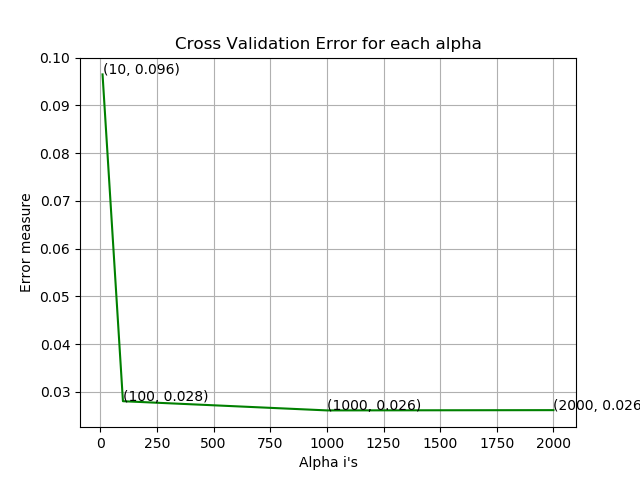

In [29]:
alpha=[10,100,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(x_trn_final,y_trn_final)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(x_trn_final, y_trn_final)
    predict_y = sig_clf.predict_proba(x_cv_final)
    cv_log_error_array.append(log_loss(y_cv_final, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



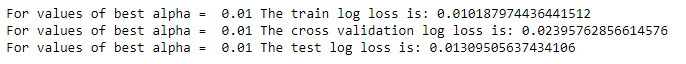

In [84]:
x_cfl=XGBClassifier(n_estimators=2000,nthread=-1)
x_cfl.fit(x_trn_final,y_trn_final,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(x_trn_final, y_trn_final)

predict_y = sig_clf.predict_proba(x_trn_final)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_trn_final, predict_y))
predict_y = sig_clf.predict_proba(x_cv_final)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_final, predict_y))
predict_y = sig_clf.predict_proba(x_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_final, predict_y))

# Summary

In [85]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = " Model Comparision "
x.field_names = ["Model",'Files','Loss']
x.add_row(["Random Model","Byte files","2.45"])
x.add_row(["KNN","Byte files","0.48"])
x.add_row(["Logistic Regression","Byte files","0.52"])
x.add_row(["Random Forest Classifier ","Byte files","0.06"])
x.add_row(["XgBoost Classifier","Byte files","0.07"])
x.add_row(["KNN","asmfiles","0.21"])
x.add_row(["Logistic Regression","asmfiles","0.38"])
x.add_row(["Random Forest Classifier ","asmfiles","0.03"])
x.add_row(["XgBoost Classifier","asmfiles","0.04"])
x.add_row(["Random Forest Classifier ","Byte files+asmfiles","0.04"])
x.add_row(["XgBoost Classifier","Byte files+asmfiles","0.02"])
x.add_row(["Logistic Regression","Byte files+asmfiles+advanced features","1.12"])
x.add_row(["XgBoost Classifier","Byte files+asmfiles+advanced features","0.013"])
print(x)

+---------------------------+---------------------------------------+-------+
|           Model           |                 Files                 |  Loss |
+---------------------------+---------------------------------------+-------+
|        Random Model       |               Byte files              |  2.45 |
|            KNN            |               Byte files              |  0.48 |
|    Logistic Regression    |               Byte files              |  0.52 |
| Random Forest Classifier  |               Byte files              |  0.06 |
|     XgBoost Classifier    |               Byte files              |  0.07 |
|            KNN            |                asmfiles               |  0.21 |
|    Logistic Regression    |                asmfiles               |  0.38 |
| Random Forest Classifier  |                asmfiles               |  0.03 |
|     XgBoost Classifier    |                asmfiles               |  0.04 |
| Random Forest Classifier  |          Byte files+asmfiles      